In [1]:
!pip install -U scikit-image
!pip install -U cython

Requirement already up-to-date: scikit-image in /home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages (0.14.0)
Requirement not upgraded as not directly required: networkx>=1.8 in /home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages (from scikit-image) (2.1)
Requirement not upgraded as not directly required: cloudpickle>=0.2.1 in /home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages (from scikit-image) (0.5.3)
Requirement not upgraded as not directly required: dask[array]>=0.9.0 in /home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages (from scikit-image) (0.18.1)
Requirement not upgraded as not directly required: scipy>=0.17.0 in /home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages (from scikit-image) (1.1.0)
Requirement not upgraded as not directly required: matplotlib>=2.0.0 in /home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages (from scikit-image) (2.2.2)
Requirement not upgraded

In [1]:
"""
Mask R-CNN
Train on the dwelling dataset.

Copyright (c) 2018 Matterport, Inc.
Licensed under the MIT License (see LICENSE for details)
Written by Waleed Abdulla

------------------------------------------------------------

Usage: import the module (see Jupyter notebooks for examples), or run from
       the command line as such:

    # Train a new model starting from pre-trained COCO weights
    python3 dwelling.py train --dataset=/images --weights=coco

    # Resume training a model that you had trained earlier
    python3 dwelling.py train --dataset=/path/to/dwelling/dataset --weights=last

    # Train a new model starting from ImageNet weights
    python3 dwelling.py train --dataset=/path/to/dwelling/dataset --weights=imagenet

    # Apply color splash to an image
    python3 dwelling.py splash --weights=/path/to/weights/file.h5 --image=<URL or path to file>

    # Apply color splash to video using the last weights you trained
    python3 dwelling.py splash --weights=last --video=<URL or path to file>
"""

import os
import sys
import json
import datetime
import numpy as np
import random
import skimage.draw
import cv2
import matplotlib
import matplotlib.pyplot as plt

# Root directory of the project
ROOT_DIR = os.path.abspath("/home/ubuntu")

import coco
# Import Mask RCNN
sys.path.append(ROOT_DIR)  # To find local version of the library
from Mask_RCNN.mrcnn.config import Config
from Mask_RCNN.mrcnn import model as modellib, utils, visualize
from Mask_RCNN.mrcnn.model import log

# Path to trained weights file
COCO_WEIGHTS_PATH = os.path.join(ROOT_DIR, "images/mask_rcnn_coco.h5")

# Directory to save logs and model checkpoints, if not provided
# through the command line argument --logs
DEFAULT_LOGS_DIR = os.path.join(ROOT_DIR, "logs")

%matplotlib inline 

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:

############################################################
#  Configurations
############################################################


class DwellingConfig(Config):
    """Configuration for training on the  dataset.
    Derives from the base Config class and overrides some values.
    """
    # Give the configuration a recognizable name
    NAME = "dwelling"

    # We use a GPU, which can fit two images.
    # Adjust down if you use a smaller GPU.
    IMAGES_PER_GPU = 2

    # Number of classes (including background)
    NUM_CLASSES = 1 + 1  # Background + dwelling

    # Number of training steps per epoch
    STEPS_PER_EPOCH = 100

    # Skip detections with < 90% confidence
    DETECTION_MIN_CONFIDENCE = 0.9
    
config = DwellingConfig()
config.display()



Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     2
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.9
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 2
IMAGE_MAX_DIM                  1024
IMAGE_META_SIZE                14
IMAGE_MIN_DIM                  800
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [1024 1024    3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE                     [28, 28]
MAX_GT_INSTA

In [3]:
def get_ax(rows=1, cols=1, size=8):
    """Return a Matplotlib Axes array to be used in
    all visualizations in the notebook. Provide a
    central point to control graph sizes.
    
    Change the default size attribute to control the size
    of rendered images
    """
    _, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
    return ax

In [4]:

############################################################
#  Dataset
############################################################

class DwellingDataset(utils.Dataset):

    def load_dwelling(self, dataset_dir, subset):
        """Load a subset of the dwelling dataset.
        dataset_dir: Root directory of the dataset.
        subset: Subset to load: train or val
        """
        # Add classes. We have only one class to add.
        self.add_class("dwelling", 1, "dwelling")

        # Train or validation dataset?
        assert subset in ["train", "val"]
        dataset_dir = os.path.join(dataset_dir, subset)

        # Load annotations
        # VGG Image Annotator saves each image in the form:
        # { 'filename': 'dwelling004.jpg',
        #   'regions': {
        #       '0': {
        #           'region_attributes': {},
        #           'shape_attributes': {
        #               'all_points_x': [...],
        #               'all_points_y': [...],
        #               'name': 'polygon'}},
        #       ... more regions ...
        #   },
        #   'size': 100202
        # }
        # We mostly care about the x and y coordinates of each region
        annotations = json.load(open(os.path.join(dataset_dir, "via_region_data.json")))
        annotations = list(annotations.values())  # don't need the dict keys

        # The VIA tool saves images in the JSON even if they don't have any
        # annotations. Skip unannotated images.
        annotations = [a for a in annotations if a['regions']]

        # Add images
        for a in annotations:
            # Get the x, y coordinates of points of the polygons that make up
            # the outline of each object instance. There are stores in the
            # shape_attributes (see json format above)
            polygons = [r['shape_attributes'] for r in a['regions'].values()]

            # load_mask() needs the image size to convert polygons to masks.
            # Unfortunately, VIA doesn't include it in JSON, so we must read
            # the image. This is only managable since the dataset is tiny.
            image_path = os.path.join(dataset_dir, a['filename'])
            image = skimage.io.imread(image_path)
            height, width = image.shape[:2]

            self.add_image(
                "dwelling",
                image_id=a['filename'],  # use file name as a unique image id
                path=image_path,
                width=width, height=height,
                polygons=polygons)

    def load_mask(self, image_id):
        """Generate instance masks for an image.
       Returns:
        masks: A bool array of shape [height, width, instance count] with
            one mask per instance.
        class_ids: a 1D array of class IDs of the instance masks.
        """
        # If not a dwelling dataset image, delegate to parent class.
        image_info = self.image_info[image_id]
        if image_info["source"] != "dwelling":
            return super(self.__class__, self).load_mask(image_id)

        # Convert polygons to a bitmap mask of shape
        # [height, width, instance_count]
        info = self.image_info[image_id]
        mask = np.zeros([info["height"], info["width"], len(info["polygons"])],
                        dtype=np.uint8)
        for i, p in enumerate(info["polygons"]):
            # Get indexes of pixels inside the polygon and set them to 1
            rr, cc = skimage.draw.polygon(p['all_points_y'], p['all_points_x'])
            mask[rr, cc, i] = 1

        # Return mask, and array of class IDs of each instance. Since we have
        # one class ID only, we return an array of 1s
        return mask.astype(np.bool), np.ones([mask.shape[-1]], dtype=np.int32)

    def image_reference(self, image_id):
        """Return the path of the image."""
        info = self.image_info[image_id]
        if info["source"] == "dwelling":
            return info["path"]
        else:
            super(self.__class__, self).image_reference(image_id)


In [5]:
    # Training dataset.
dataset_train = DwellingDataset()
dataset_train.load_dwelling("/home/ubuntu/images/dataset", "train")
dataset_train.prepare()

    # Validation dataset
dataset_val = DwellingDataset()
dataset_val.load_dwelling("/home/ubuntu/images/dataset", "val")
dataset_val.prepare()

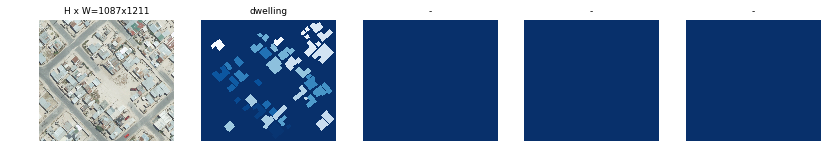

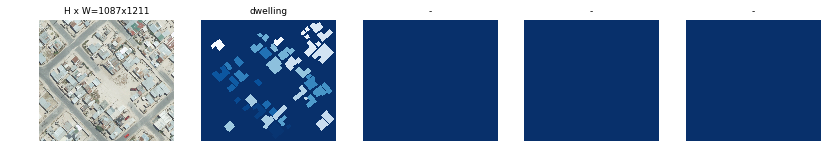

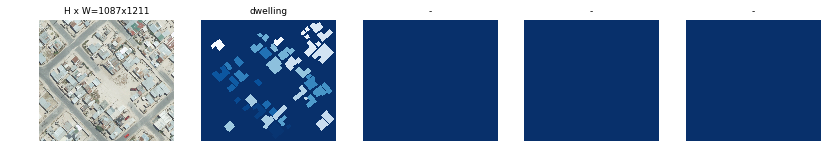

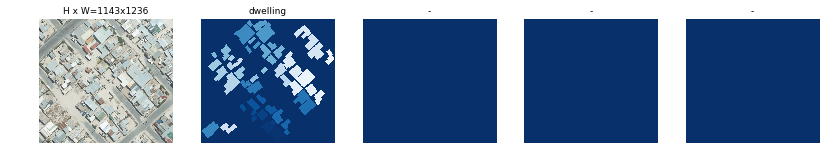

In [6]:
# Load and display random samples
image_ids = np.random.choice(dataset_train.image_ids, 4)
for image_id in image_ids:
    image = dataset_train.load_image(image_id)
    mask, class_ids = dataset_train.load_mask(image_id)
    visualize.display_top_masks(image, mask, class_ids, dataset_train.class_names)

In [6]:
model = modellib.MaskRCNN(mode="training", config=config,
                          model_dir=DEFAULT_LOGS_DIR)


In [7]:
# Which weights to start with?
init_with = "coco"  # imagenet, coco, or last

if init_with == "imagenet":
    model.load_weights(model.get_imagenet_weights(), by_name=True)
elif init_with == "coco":
    # Load weights trained on MS COCO, but skip layers that
    # are different due to the different number of classes
    # See README for instructions to download the COCO weights
    model.load_weights(COCO_WEIGHTS_PATH, by_name=True,
                       exclude=["mrcnn_class_logits", "mrcnn_bbox_fc", 
                                "mrcnn_bbox", "mrcnn_mask"])
elif init_with == "last":
    # Load the last model you trained and continue training
    model.load_weights(model.find_last(), by_name=True)
    


In [8]:
# Fine tune all layers
# Passing layers="all" trains all layers. You can also 
# pass a regular expression to select which layers to
# train by name pattern.
model.train(dataset_train, dataset_val, 
            learning_rate=config.LEARNING_RATE,
            epochs=5, 
            layers="all")


Starting at epoch 0. LR=0.001

Checkpoint Path: /home/ubuntu/logs/dwelling20180906T1440/mask_rcnn_dwelling_{epoch:04d}.h5
Selecting layers to train
conv1                  (Conv2D)
bn_conv1               (BatchNorm)
res2a_branch2a         (Conv2D)
bn2a_branch2a          (BatchNorm)
res2a_branch2b         (Conv2D)
bn2a_branch2b          (BatchNorm)
res2a_branch2c         (Conv2D)
res2a_branch1          (Conv2D)
bn2a_branch2c          (BatchNorm)
bn2a_branch1           (BatchNorm)
res2b_branch2a         (Conv2D)
bn2b_branch2a          (BatchNorm)
res2b_branch2b         (Conv2D)
bn2b_branch2b          (BatchNorm)
res2b_branch2c         (Conv2D)
bn2b_branch2c          (BatchNorm)
res2c_branch2a         (Conv2D)
bn2c_branch2a          (BatchNorm)
res2c_branch2b         (Conv2D)
bn2c_branch2b          (BatchNorm)
res2c_branch2c         (Conv2D)
bn2c_branch2c          (BatchNorm)
res3a_branch2a         (Conv2D)
bn3a_branch2a          (BatchNorm)
res3a_branch2b         (Conv2D)
bn3a_branch2b  

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:100: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras/engine/training_generator.py:44: UserWarning: Using a generator with `use_multiprocessing=True` and multiple workers may duplicate your data. Please consider using the`keras.utils.Sequence class.
  UserWarning('Using a generator with `use_multiprocessing=True`'


Epoch 1/5


/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/skimage/transform/_warps.py:110:

  1/100 [..............................] - ETA: 1:39:23 - loss: 5.1466 - rpn_class_loss: 0.8851 - rpn_bbox_loss: 0.2416 - mrcnn_class_loss: 2.2013 - mrcnn_bbox_loss: 0.9092 - mrcnn_mask_loss: 0.9094

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


  2/100 [..............................] - ETA: 49:59 - loss: 4.8116 - rpn_class_loss: 0.7815 - rpn_bbox_loss: 0.2363 - mrcnn_class_loss: 2.0424 - mrcnn_bbox_loss: 0.8667 - mrcnn_mask_loss: 0.8847  

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


  3/100 [..............................] - ETA: 33:32 - loss: 4.4279 - rpn_class_loss: 0.6706 - rpn_bbox_loss: 0.2300 - mrcnn_class_loss: 1.8235 - mrcnn_bbox_loss: 0.8376 - mrcnn_mask_loss: 0.8662

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/skimage/transform/_warps.py:110:

  5/100 [>.............................] - ETA: 20:23 - loss: 3.6646 - rpn_class_loss: 0.4606 - rpn_bbox_loss: 0.2149 - mrcnn_class_loss: 1.3906 - mrcnn_bbox_loss: 0.7573 - mrcnn_mask_loss: 0.8411

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


  6/100 [>.............................] - ETA: 17:02 - loss: 3.4410 - rpn_class_loss: 0.4095 - rpn_bbox_loss: 0.2123 - mrcnn_class_loss: 1.2752 - mrcnn_bbox_loss: 0.7276 - mrcnn_mask_loss: 0.8164

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


  7/100 [=>............................] - ETA: 14:39 - loss: 3.3059 - rpn_class_loss: 0.3713 - rpn_bbox_loss: 0.2196 - mrcnn_class_loss: 1.2122 - mrcnn_bbox_loss: 0.7144 - mrcnn_mask_loss: 0.7884

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


  8/100 [=>............................] - ETA: 12:53 - loss: 3.1901 - rpn_class_loss: 0.3398 - rpn_bbox_loss: 0.2287 - mrcnn_class_loss: 1.1583 - mrcnn_bbox_loss: 0.7002 - mrcnn_mask_loss: 0.7630

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


  9/100 [=>............................] - ETA: 11:30 - loss: 3.0731 - rpn_class_loss: 0.3210 - rpn_bbox_loss: 0.2240 - mrcnn_class_loss: 1.0927 - mrcnn_bbox_loss: 0.6956 - mrcnn_mask_loss: 0.7399

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 10/100 [==>...........................] - ETA: 10:22 - loss: 2.9581 - rpn_class_loss: 0.3038 - rpn_bbox_loss: 0.2190 - mrcnn_class_loss: 1.0335 - mrcnn_bbox_loss: 0.6832 - mrcnn_mask_loss: 0.7185

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 11/100 [==>...........................] - ETA: 9:27 - loss: 2.8696 - rpn_class_loss: 0.2883 - rpn_bbox_loss: 0.2177 - mrcnn_class_loss: 0.9957 - mrcnn_bbox_loss: 0.6687 - mrcnn_mask_loss: 0.6993 

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 12/100 [==>...........................] - ETA: 8:41 - loss: 2.7837 - rpn_class_loss: 0.2741 - rpn_bbox_loss: 0.2147 - mrcnn_class_loss: 0.9600 - mrcnn_bbox_loss: 0.6523 - mrcnn_mask_loss: 0.6826

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 13/100 [==>...........................] - ETA: 8:02 - loss: 2.6971 - rpn_class_loss: 0.2599 - rpn_bbox_loss: 0.2088 - mrcnn_class_loss: 0.9227 - mrcnn_bbox_loss: 0.6395 - mrcnn_mask_loss: 0.6663

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/skimage/transform/_warps.py:110:

 14/100 [===>..........................] - ETA: 7:28 - loss: 2.6256 - rpn_class_loss: 0.2481 - rpn_bbox_loss: 0.2043 - mrcnn_class_loss: 0.8949 - mrcnn_bbox_loss: 0.6259 - mrcnn_mask_loss: 0.6524

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 15/100 [===>..........................] - ETA: 6:59 - loss: 2.5642 - rpn_class_loss: 0.2377 - rpn_bbox_loss: 0.2048 - mrcnn_class_loss: 0.8696 - mrcnn_bbox_loss: 0.6129 - mrcnn_mask_loss: 0.6392

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 16/100 [===>..........................] - ETA: 6:34 - loss: 2.5000 - rpn_class_loss: 0.2264 - rpn_bbox_loss: 0.2040 - mrcnn_class_loss: 0.8449 - mrcnn_bbox_loss: 0.5971 - mrcnn_mask_loss: 0.6276

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 17/100 [====>.........................] - ETA: 6:10 - loss: 2.4351 - rpn_class_loss: 0.2186 - rpn_bbox_loss: 0.1992 - mrcnn_class_loss: 0.8183 - mrcnn_bbox_loss: 0.5840 - mrcnn_mask_loss: 0.6149

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 18/100 [====>.........................] - ETA: 5:50 - loss: 2.3677 - rpn_class_loss: 0.2096 - rpn_bbox_loss: 0.1952 - mrcnn_class_loss: 0.7914 - mrcnn_bbox_loss: 0.5683 - mrcnn_mask_loss: 0.6032

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/skimage/transform/_warps.py:110:

 19/100 [====>.........................] - ETA: 5:31 - loss: 2.3101 - rpn_class_loss: 0.2015 - rpn_bbox_loss: 0.1930 - mrcnn_class_loss: 0.7690 - mrcnn_bbox_loss: 0.5548 - mrcnn_mask_loss: 0.5919

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 21/100 [=====>........................] - ETA: 4:59 - loss: 2.1973 - rpn_class_loss: 0.1853 - rpn_bbox_loss: 0.1861 - mrcnn_class_loss: 0.7248 - mrcnn_bbox_loss: 0.5325 - mrcnn_mask_loss: 0.5685

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 22/100 [=====>........................] - ETA: 4:45 - loss: 2.1460 - rpn_class_loss: 0.1785 - rpn_bbox_loss: 0.1822 - mrcnn_class_loss: 0.7075 - mrcnn_bbox_loss: 0.5209 - mrcnn_mask_loss: 0.5568

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 23/100 [=====>........................] - ETA: 4:32 - loss: 2.0961 - rpn_class_loss: 0.1730 - rpn_bbox_loss: 0.1785 - mrcnn_class_loss: 0.6891 - mrcnn_bbox_loss: 0.5099 - mrcnn_mask_loss: 0.5455

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/skimage/transform/_warps.py:110:

 24/100 [======>.......................] - ETA: 4:21 - loss: 2.0511 - rpn_class_loss: 0.1678 - rpn_bbox_loss: 0.1748 - mrcnn_class_loss: 0.6737 - mrcnn_bbox_loss: 0.4997 - mrcnn_mask_loss: 0.5350

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 27/100 [=======>......................] - ETA: 3:50 - loss: 1.9372 - rpn_class_loss: 0.1546 - rpn_bbox_loss: 0.1683 - mrcnn_class_loss: 0.6382 - mrcnn_bbox_loss: 0.4702 - mrcnn_mask_loss: 0.5058

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 28/100 [=======>......................] - ETA: 3:41 - loss: 1.8952 - rpn_class_loss: 0.1497 - rpn_bbox_loss: 0.1653 - mrcnn_class_loss: 0.6239 - mrcnn_bbox_loss: 0.4603 - mrcnn_mask_loss: 0.4961

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/skimage/transform/_warps.py:110:

 30/100 [========>.....................] - ETA: 3:25 - loss: 1.8277 - rpn_class_loss: 0.1418 - rpn_bbox_loss: 0.1595 - mrcnn_class_loss: 0.6039 - mrcnn_bbox_loss: 0.4435 - mrcnn_mask_loss: 0.4791

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 32/100 [========>.....................] - ETA: 3:10 - loss: 1.7624 - rpn_class_loss: 0.1340 - rpn_bbox_loss: 0.1540 - mrcnn_class_loss: 0.5844 - mrcnn_bbox_loss: 0.4274 - mrcnn_mask_loss: 0.4626

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/skimage/transform/_warps.py:110:

 33/100 [========>.....................] - ETA: 3:04 - loss: 1.7372 - rpn_class_loss: 0.1306 - rpn_bbox_loss: 0.1519 - mrcnn_class_loss: 0.5784 - mrcnn_bbox_loss: 0.4204 - mrcnn_mask_loss: 0.4559

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 35/100 [=========>....................] - ETA: 2:51 - loss: 1.6796 - rpn_class_loss: 0.1241 - rpn_bbox_loss: 0.1471 - mrcnn_class_loss: 0.5615 - mrcnn_bbox_loss: 0.4059 - mrcnn_mask_loss: 0.4410

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 36/100 [=========>....................] - ETA: 2:46 - loss: 1.6559 - rpn_class_loss: 0.1210 - rpn_bbox_loss: 0.1449 - mrcnn_class_loss: 0.5550 - mrcnn_bbox_loss: 0.4001 - mrcnn_mask_loss: 0.4350

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 37/100 [==========>...................] - ETA: 2:40 - loss: 1.6313 - rpn_class_loss: 0.1184 - rpn_bbox_loss: 0.1431 - mrcnn_class_loss: 0.5475 - mrcnn_bbox_loss: 0.3934 - mrcnn_mask_loss: 0.4289

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 38/100 [==========>...................] - ETA: 2:35 - loss: 1.6080 - rpn_class_loss: 0.1157 - rpn_bbox_loss: 0.1416 - mrcnn_class_loss: 0.5402 - mrcnn_bbox_loss: 0.3876 - mrcnn_mask_loss: 0.4230

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/skimage/transform/_warps.py:110:

 40/100 [===========>..................] - ETA: 2:25 - loss: 1.5596 - rpn_class_loss: 0.1109 - rpn_bbox_loss: 0.1375 - mrcnn_class_loss: 0.5258 - mrcnn_bbox_loss: 0.3747 - mrcnn_mask_loss: 0.4107

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 41/100 [===========>..................] - ETA: 2:20 - loss: 1.5362 - rpn_class_loss: 0.1084 - rpn_bbox_loss: 0.1355 - mrcnn_class_loss: 0.5181 - mrcnn_bbox_loss: 0.3692 - mrcnn_mask_loss: 0.4051

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 42/100 [===========>..................] - ETA: 2:16 - loss: 1.5149 - rpn_class_loss: 0.1062 - rpn_bbox_loss: 0.1340 - mrcnn_class_loss: 0.5116 - mrcnn_bbox_loss: 0.3633 - mrcnn_mask_loss: 0.3998

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 43/100 [===========>..................] - ETA: 2:12 - loss: 1.4947 - rpn_class_loss: 0.1041 - rpn_bbox_loss: 0.1322 - mrcnn_class_loss: 0.5067 - mrcnn_bbox_loss: 0.3570 - mrcnn_mask_loss: 0.3947

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 44/100 [============>.................] - ETA: 2:08 - loss: 1.4749 - rpn_class_loss: 0.1022 - rpn_bbox_loss: 0.1303 - mrcnn_class_loss: 0.5017 - mrcnn_bbox_loss: 0.3511 - mrcnn_mask_loss: 0.3897

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 46/100 [============>.................] - ETA: 2:00 - loss: 1.4364 - rpn_class_loss: 0.0984 - rpn_bbox_loss: 0.1270 - mrcnn_class_loss: 0.4907 - mrcnn_bbox_loss: 0.3402 - mrcnn_mask_loss: 0.3800

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 47/100 [=============>................] - ETA: 1:56 - loss: 1.4186 - rpn_class_loss: 0.0969 - rpn_bbox_loss: 0.1255 - mrcnn_class_loss: 0.4852 - mrcnn_bbox_loss: 0.3353 - mrcnn_mask_loss: 0.3758

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 48/100 [=============>................] - ETA: 1:52 - loss: 1.4013 - rpn_class_loss: 0.0953 - rpn_bbox_loss: 0.1239 - mrcnn_class_loss: 0.4797 - mrcnn_bbox_loss: 0.3307 - mrcnn_mask_loss: 0.3717

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 49/100 [=============>................] - ETA: 1:49 - loss: 1.3839 - rpn_class_loss: 0.0937 - rpn_bbox_loss: 0.1222 - mrcnn_class_loss: 0.4743 - mrcnn_bbox_loss: 0.3263 - mrcnn_mask_loss: 0.3673

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 50/100 [==============>...............] - ETA: 1:46 - loss: 1.3673 - rpn_class_loss: 0.0919 - rpn_bbox_loss: 0.1207 - mrcnn_class_loss: 0.4699 - mrcnn_bbox_loss: 0.3216 - mrcnn_mask_loss: 0.3632

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 51/100 [==============>...............] - ETA: 1:42 - loss: 1.3504 - rpn_class_loss: 0.0902 - rpn_bbox_loss: 0.1192 - mrcnn_class_loss: 0.4649 - mrcnn_bbox_loss: 0.3172 - mrcnn_mask_loss: 0.3589

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 52/100 [==============>...............] - ETA: 1:39 - loss: 1.3339 - rpn_class_loss: 0.0887 - rpn_bbox_loss: 0.1179 - mrcnn_class_loss: 0.4591 - mrcnn_bbox_loss: 0.3131 - mrcnn_mask_loss: 0.3551

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 53/100 [==============>...............] - ETA: 1:36 - loss: 1.3179 - rpn_class_loss: 0.0871 - rpn_bbox_loss: 0.1164 - mrcnn_class_loss: 0.4540 - mrcnn_bbox_loss: 0.3088 - mrcnn_mask_loss: 0.3515

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/skimage/transform/_warps.py:110:

 54/100 [===============>..............] - ETA: 1:33 - loss: 1.3033 - rpn_class_loss: 0.0858 - rpn_bbox_loss: 0.1150 - mrcnn_class_loss: 0.4503 - mrcnn_bbox_loss: 0.3045 - mrcnn_mask_loss: 0.3478

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 56/100 [===============>..............] - ETA: 1:27 - loss: 1.2750 - rpn_class_loss: 0.0831 - rpn_bbox_loss: 0.1122 - mrcnn_class_loss: 0.4420 - mrcnn_bbox_loss: 0.2970 - mrcnn_mask_loss: 0.3407

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 57/100 [================>.............] - ETA: 1:24 - loss: 1.2612 - rpn_class_loss: 0.0819 - rpn_bbox_loss: 0.1111 - mrcnn_class_loss: 0.4375 - mrcnn_bbox_loss: 0.2933 - mrcnn_mask_loss: 0.3374

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 58/100 [================>.............] - ETA: 1:21 - loss: 1.2466 - rpn_class_loss: 0.0806 - rpn_bbox_loss: 0.1099 - mrcnn_class_loss: 0.4323 - mrcnn_bbox_loss: 0.2895 - mrcnn_mask_loss: 0.3342

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 59/100 [================>.............] - ETA: 1:19 - loss: 1.2333 - rpn_class_loss: 0.0795 - rpn_bbox_loss: 0.1089 - mrcnn_class_loss: 0.4281 - mrcnn_bbox_loss: 0.2858 - mrcnn_mask_loss: 0.3311

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 60/100 [=================>............] - ETA: 1:16 - loss: 1.2205 - rpn_class_loss: 0.0785 - rpn_bbox_loss: 0.1076 - mrcnn_class_loss: 0.4239 - mrcnn_bbox_loss: 0.2823 - mrcnn_mask_loss: 0.3282

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 61/100 [=================>............] - ETA: 1:13 - loss: 1.2078 - rpn_class_loss: 0.0774 - rpn_bbox_loss: 0.1064 - mrcnn_class_loss: 0.4199 - mrcnn_bbox_loss: 0.2790 - mrcnn_mask_loss: 0.3252

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 63/100 [=================>............] - ETA: 1:08 - loss: 1.1830 - rpn_class_loss: 0.0752 - rpn_bbox_loss: 0.1041 - mrcnn_class_loss: 0.4119 - mrcnn_bbox_loss: 0.2723 - mrcnn_mask_loss: 0.3195

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 64/100 [==================>...........] - ETA: 1:06 - loss: 1.1706 - rpn_class_loss: 0.0742 - rpn_bbox_loss: 0.1029 - mrcnn_class_loss: 0.4080 - mrcnn_bbox_loss: 0.2689 - mrcnn_mask_loss: 0.3165

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 65/100 [==================>...........] - ETA: 1:04 - loss: 1.1595 - rpn_class_loss: 0.0731 - rpn_bbox_loss: 0.1019 - mrcnn_class_loss: 0.4050 - mrcnn_bbox_loss: 0.2656 - mrcnn_mask_loss: 0.3137

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 67/100 [===================>..........] - ETA: 59s - loss: 1.1373 - rpn_class_loss: 0.0711 - rpn_bbox_loss: 0.0998 - mrcnn_class_loss: 0.3984 - mrcnn_bbox_loss: 0.2595 - mrcnn_mask_loss: 0.3085 

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 68/100 [===================>..........] - ETA: 57s - loss: 1.1270 - rpn_class_loss: 0.0701 - rpn_bbox_loss: 0.0990 - mrcnn_class_loss: 0.3948 - mrcnn_bbox_loss: 0.2570 - mrcnn_mask_loss: 0.3061

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/skimage/transform/_warps.py:110:

 69/100 [===================>..........] - ETA: 55s - loss: 1.1161 - rpn_class_loss: 0.0692 - rpn_bbox_loss: 0.0980 - mrcnn_class_loss: 0.3908 - mrcnn_bbox_loss: 0.2543 - mrcnn_mask_loss: 0.3037

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 70/100 [====================>.........] - ETA: 52s - loss: 1.1051 - rpn_class_loss: 0.0683 - rpn_bbox_loss: 0.0970 - mrcnn_class_loss: 0.3873 - mrcnn_bbox_loss: 0.2513 - mrcnn_mask_loss: 0.3011

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 71/100 [====================>.........] - ETA: 50s - loss: 1.0944 - rpn_class_loss: 0.0675 - rpn_bbox_loss: 0.0961 - mrcnn_class_loss: 0.3833 - mrcnn_bbox_loss: 0.2487 - mrcnn_mask_loss: 0.2988

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 73/100 [====================>.........] - ETA: 46s - loss: 1.0738 - rpn_class_loss: 0.0658 - rpn_bbox_loss: 0.0942 - mrcnn_class_loss: 0.3762 - mrcnn_bbox_loss: 0.2436 - mrcnn_mask_loss: 0.2940

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/skimage/transform/_warps.py:110:

 74/100 [=====================>........] - ETA: 44s - loss: 1.0642 - rpn_class_loss: 0.0650 - rpn_bbox_loss: 0.0933 - mrcnn_class_loss: 0.3728 - mrcnn_bbox_loss: 0.2412 - mrcnn_mask_loss: 0.2919

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 75/100 [=====================>........] - ETA: 42s - loss: 1.0548 - rpn_class_loss: 0.0642 - rpn_bbox_loss: 0.0925 - mrcnn_class_loss: 0.3694 - mrcnn_bbox_loss: 0.2391 - mrcnn_mask_loss: 0.2896

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 76/100 [=====================>........] - ETA: 40s - loss: 1.0452 - rpn_class_loss: 0.0634 - rpn_bbox_loss: 0.0916 - mrcnn_class_loss: 0.3659 - mrcnn_bbox_loss: 0.2366 - mrcnn_mask_loss: 0.2876

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 77/100 [======================>.......] - ETA: 38s - loss: 1.0367 - rpn_class_loss: 0.0627 - rpn_bbox_loss: 0.0907 - mrcnn_class_loss: 0.3636 - mrcnn_bbox_loss: 0.2342 - mrcnn_mask_loss: 0.2855

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 78/100 [======================>.......] - ETA: 36s - loss: 1.0277 - rpn_class_loss: 0.0620 - rpn_bbox_loss: 0.0899 - mrcnn_class_loss: 0.3604 - mrcnn_bbox_loss: 0.2319 - mrcnn_mask_loss: 0.2835

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 79/100 [======================>.......] - ETA: 34s - loss: 1.0185 - rpn_class_loss: 0.0612 - rpn_bbox_loss: 0.0891 - mrcnn_class_loss: 0.3572 - mrcnn_bbox_loss: 0.2296 - mrcnn_mask_loss: 0.2813

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 80/100 [=======================>......] - ETA: 33s - loss: 1.0103 - rpn_class_loss: 0.0608 - rpn_bbox_loss: 0.0883 - mrcnn_class_loss: 0.3545 - mrcnn_bbox_loss: 0.2274 - mrcnn_mask_loss: 0.2794

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 81/100 [=======================>......] - ETA: 31s - loss: 1.0025 - rpn_class_loss: 0.0601 - rpn_bbox_loss: 0.0875 - mrcnn_class_loss: 0.3521 - mrcnn_bbox_loss: 0.2252 - mrcnn_mask_loss: 0.2776

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 82/100 [=======================>......] - ETA: 29s - loss: 0.9942 - rpn_class_loss: 0.0594 - rpn_bbox_loss: 0.0867 - mrcnn_class_loss: 0.3495 - mrcnn_bbox_loss: 0.2231 - mrcnn_mask_loss: 0.2756

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 83/100 [=======================>......] - ETA: 27s - loss: 0.9861 - rpn_class_loss: 0.0587 - rpn_bbox_loss: 0.0859 - mrcnn_class_loss: 0.3471 - mrcnn_bbox_loss: 0.2209 - mrcnn_mask_loss: 0.2736

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 84/100 [========================>.....] - ETA: 25s - loss: 0.9781 - rpn_class_loss: 0.0581 - rpn_bbox_loss: 0.0851 - mrcnn_class_loss: 0.3443 - mrcnn_bbox_loss: 0.2189 - mrcnn_mask_loss: 0.2717

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 85/100 [========================>.....] - ETA: 24s - loss: 0.9705 - rpn_class_loss: 0.0574 - rpn_bbox_loss: 0.0844 - mrcnn_class_loss: 0.3415 - mrcnn_bbox_loss: 0.2171 - mrcnn_mask_loss: 0.2700

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 87/100 [=========================>....] - ETA: 20s - loss: 0.9553 - rpn_class_loss: 0.0562 - rpn_bbox_loss: 0.0830 - mrcnn_class_loss: 0.3364 - mrcnn_bbox_loss: 0.2131 - mrcnn_mask_loss: 0.2667

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 88/100 [=========================>....] - ETA: 19s - loss: 0.9480 - rpn_class_loss: 0.0556 - rpn_bbox_loss: 0.0824 - mrcnn_class_loss: 0.3335 - mrcnn_bbox_loss: 0.2114 - mrcnn_mask_loss: 0.2651

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 89/100 [=========================>....] - ETA: 17s - loss: 0.9410 - rpn_class_loss: 0.0551 - rpn_bbox_loss: 0.0817 - mrcnn_class_loss: 0.3311 - mrcnn_bbox_loss: 0.2097 - mrcnn_mask_loss: 0.2635

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 90/100 [==========================>...] - ETA: 15s - loss: 0.9339 - rpn_class_loss: 0.0546 - rpn_bbox_loss: 0.0810 - mrcnn_class_loss: 0.3285 - mrcnn_bbox_loss: 0.2079 - mrcnn_mask_loss: 0.2619

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 91/100 [==========================>...] - ETA: 14s - loss: 0.9271 - rpn_class_loss: 0.0540 - rpn_bbox_loss: 0.0803 - mrcnn_class_loss: 0.3262 - mrcnn_bbox_loss: 0.2063 - mrcnn_mask_loss: 0.2604

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 92/100 [==========================>...] - ETA: 12s - loss: 0.9205 - rpn_class_loss: 0.0536 - rpn_bbox_loss: 0.0797 - mrcnn_class_loss: 0.3237 - mrcnn_bbox_loss: 0.2047 - mrcnn_mask_loss: 0.2588

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 93/100 [==========================>...] - ETA: 10s - loss: 0.9138 - rpn_class_loss: 0.0530 - rpn_bbox_loss: 0.0791 - mrcnn_class_loss: 0.3213 - mrcnn_bbox_loss: 0.2030 - mrcnn_mask_loss: 0.2574

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 94/100 [===========================>..] - ETA: 9s - loss: 0.9072 - rpn_class_loss: 0.0525 - rpn_bbox_loss: 0.0785 - mrcnn_class_loss: 0.3189 - mrcnn_bbox_loss: 0.2013 - mrcnn_mask_loss: 0.2559 

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 95/100 [===========================>..] - ETA: 7s - loss: 0.9009 - rpn_class_loss: 0.0520 - rpn_bbox_loss: 0.0780 - mrcnn_class_loss: 0.3165 - mrcnn_bbox_loss: 0.1998 - mrcnn_mask_loss: 0.2546

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 96/100 [===========================>..] - ETA: 6s - loss: 0.8950 - rpn_class_loss: 0.0515 - rpn_bbox_loss: 0.0775 - mrcnn_class_loss: 0.3147 - mrcnn_bbox_loss: 0.1981 - mrcnn_mask_loss: 0.2531

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 97/100 [============================>.] - ETA: 4s - loss: 0.8884 - rpn_class_loss: 0.0511 - rpn_bbox_loss: 0.0769 - mrcnn_class_loss: 0.3124 - mrcnn_bbox_loss: 0.1964 - mrcnn_mask_loss: 0.2516

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 98/100 [============================>.] - ETA: 3s - loss: 0.8821 - rpn_class_loss: 0.0506 - rpn_bbox_loss: 0.0763 - mrcnn_class_loss: 0.3100 - mrcnn_bbox_loss: 0.1948 - mrcnn_mask_loss: 0.2503

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 99/100 [============================>.] - ETA: 1s - loss: 0.8760 - rpn_class_loss: 0.0501 - rpn_bbox_loss: 0.0757 - mrcnn_class_loss: 0.3077 - mrcnn_bbox_loss: 0.1934 - mrcnn_mask_loss: 0.2490

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras/engine/training_generator.

100/100 [==============================] - 277s 3s/step - loss: 0.8701 - rpn_class_loss: 0.0497 - rpn_bbox_loss: 0.0752 - mrcnn_class_loss: 0.3057 - mrcnn_bbox_loss: 0.1918 - mrcnn_mask_loss: 0.2478 - val_loss: 0.9731 - val_rpn_class_loss: 0.0610 - val_rpn_bbox_loss: 0.0867 - val_mrcnn_class_loss: 0.4325 - val_mrcnn_bbox_loss: 0.1851 - val_mrcnn_mask_loss: 0.2079


/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/skimage/transform/_warps.py:110:

Epoch 2/5
  2/100 [..............................] - ETA: 1:07 - loss: 0.2512 - rpn_class_loss: 0.0043 - rpn_bbox_loss: 0.0174 - mrcnn_class_loss: 0.0803 - mrcnn_bbox_loss: 0.0391 - mrcnn_mask_loss: 0.1102

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


  3/100 [..............................] - ETA: 1:06 - loss: 0.2544 - rpn_class_loss: 0.0041 - rpn_bbox_loss: 0.0175 - mrcnn_class_loss: 0.0861 - mrcnn_bbox_loss: 0.0365 - mrcnn_mask_loss: 0.1102

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


  5/100 [>.............................] - ETA: 1:06 - loss: 0.2593 - rpn_class_loss: 0.0034 - rpn_bbox_loss: 0.0182 - mrcnn_class_loss: 0.0858 - mrcnn_bbox_loss: 0.0384 - mrcnn_mask_loss: 0.1134

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


  6/100 [>.............................] - ETA: 1:06 - loss: 0.2600 - rpn_class_loss: 0.0034 - rpn_bbox_loss: 0.0193 - mrcnn_class_loss: 0.0845 - mrcnn_bbox_loss: 0.0371 - mrcnn_mask_loss: 0.1157

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


  7/100 [=>............................] - ETA: 1:08 - loss: 0.2605 - rpn_class_loss: 0.0036 - rpn_bbox_loss: 0.0203 - mrcnn_class_loss: 0.0823 - mrcnn_bbox_loss: 0.0376 - mrcnn_mask_loss: 0.1167

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


  8/100 [=>............................] - ETA: 1:08 - loss: 0.2645 - rpn_class_loss: 0.0042 - rpn_bbox_loss: 0.0202 - mrcnn_class_loss: 0.0826 - mrcnn_bbox_loss: 0.0388 - mrcnn_mask_loss: 0.1186

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


  9/100 [=>............................] - ETA: 1:08 - loss: 0.2627 - rpn_class_loss: 0.0044 - rpn_bbox_loss: 0.0207 - mrcnn_class_loss: 0.0812 - mrcnn_bbox_loss: 0.0381 - mrcnn_mask_loss: 0.1183

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/skimage/transform/_warps.py:110:

 10/100 [==>...........................] - ETA: 1:09 - loss: 0.2602 - rpn_class_loss: 0.0053 - rpn_bbox_loss: 0.0202 - mrcnn_class_loss: 0.0787 - mrcnn_bbox_loss: 0.0376 - mrcnn_mask_loss: 0.1183

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 11/100 [==>...........................] - ETA: 1:09 - loss: 0.2612 - rpn_class_loss: 0.0060 - rpn_bbox_loss: 0.0198 - mrcnn_class_loss: 0.0797 - mrcnn_bbox_loss: 0.0374 - mrcnn_mask_loss: 0.1183

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 12/100 [==>...........................] - ETA: 1:09 - loss: 0.2579 - rpn_class_loss: 0.0056 - rpn_bbox_loss: 0.0196 - mrcnn_class_loss: 0.0782 - mrcnn_bbox_loss: 0.0365 - mrcnn_mask_loss: 0.1180

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 14/100 [===>..........................] - ETA: 1:09 - loss: 0.2515 - rpn_class_loss: 0.0051 - rpn_bbox_loss: 0.0194 - mrcnn_class_loss: 0.0750 - mrcnn_bbox_loss: 0.0350 - mrcnn_mask_loss: 0.1170

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/skimage/transform/_warps.py:110:

 15/100 [===>..........................] - ETA: 1:09 - loss: 0.2498 - rpn_class_loss: 0.0051 - rpn_bbox_loss: 0.0198 - mrcnn_class_loss: 0.0734 - mrcnn_bbox_loss: 0.0346 - mrcnn_mask_loss: 0.1169

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 16/100 [===>..........................] - ETA: 1:08 - loss: 0.2516 - rpn_class_loss: 0.0051 - rpn_bbox_loss: 0.0198 - mrcnn_class_loss: 0.0747 - mrcnn_bbox_loss: 0.0349 - mrcnn_mask_loss: 0.1171

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 17/100 [====>.........................] - ETA: 1:08 - loss: 0.2505 - rpn_class_loss: 0.0050 - rpn_bbox_loss: 0.0196 - mrcnn_class_loss: 0.0749 - mrcnn_bbox_loss: 0.0344 - mrcnn_mask_loss: 0.1167

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 18/100 [====>.........................] - ETA: 1:07 - loss: 0.2506 - rpn_class_loss: 0.0048 - rpn_bbox_loss: 0.0194 - mrcnn_class_loss: 0.0752 - mrcnn_bbox_loss: 0.0342 - mrcnn_mask_loss: 0.1169

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 19/100 [====>.........................] - ETA: 1:07 - loss: 0.2506 - rpn_class_loss: 0.0047 - rpn_bbox_loss: 0.0191 - mrcnn_class_loss: 0.0758 - mrcnn_bbox_loss: 0.0342 - mrcnn_mask_loss: 0.1169

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 20/100 [=====>........................] - ETA: 1:06 - loss: 0.2490 - rpn_class_loss: 0.0046 - rpn_bbox_loss: 0.0188 - mrcnn_class_loss: 0.0756 - mrcnn_bbox_loss: 0.0337 - mrcnn_mask_loss: 0.1164

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 21/100 [=====>........................] - ETA: 1:05 - loss: 0.2484 - rpn_class_loss: 0.0045 - rpn_bbox_loss: 0.0187 - mrcnn_class_loss: 0.0754 - mrcnn_bbox_loss: 0.0336 - mrcnn_mask_loss: 0.1163

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 22/100 [=====>........................] - ETA: 1:05 - loss: 0.2488 - rpn_class_loss: 0.0043 - rpn_bbox_loss: 0.0186 - mrcnn_class_loss: 0.0764 - mrcnn_bbox_loss: 0.0337 - mrcnn_mask_loss: 0.1158

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 23/100 [=====>........................] - ETA: 1:04 - loss: 0.2493 - rpn_class_loss: 0.0055 - rpn_bbox_loss: 0.0185 - mrcnn_class_loss: 0.0762 - mrcnn_bbox_loss: 0.0334 - mrcnn_mask_loss: 0.1157

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 24/100 [======>.......................] - ETA: 1:03 - loss: 0.2481 - rpn_class_loss: 0.0054 - rpn_bbox_loss: 0.0183 - mrcnn_class_loss: 0.0758 - mrcnn_bbox_loss: 0.0332 - mrcnn_mask_loss: 0.1154

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 25/100 [======>.......................] - ETA: 1:03 - loss: 0.2468 - rpn_class_loss: 0.0056 - rpn_bbox_loss: 0.0182 - mrcnn_class_loss: 0.0752 - mrcnn_bbox_loss: 0.0328 - mrcnn_mask_loss: 0.1150

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 26/100 [======>.......................] - ETA: 1:02 - loss: 0.2468 - rpn_class_loss: 0.0058 - rpn_bbox_loss: 0.0180 - mrcnn_class_loss: 0.0760 - mrcnn_bbox_loss: 0.0326 - mrcnn_mask_loss: 0.1145

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 27/100 [=======>......................] - ETA: 1:01 - loss: 0.2453 - rpn_class_loss: 0.0056 - rpn_bbox_loss: 0.0178 - mrcnn_class_loss: 0.0751 - mrcnn_bbox_loss: 0.0323 - mrcnn_mask_loss: 0.1144

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 29/100 [=======>......................] - ETA: 1:00 - loss: 0.2439 - rpn_class_loss: 0.0053 - rpn_bbox_loss: 0.0176 - mrcnn_class_loss: 0.0754 - mrcnn_bbox_loss: 0.0317 - mrcnn_mask_loss: 0.1138

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 30/100 [========>.....................] - ETA: 59s - loss: 0.2426 - rpn_class_loss: 0.0052 - rpn_bbox_loss: 0.0174 - mrcnn_class_loss: 0.0752 - mrcnn_bbox_loss: 0.0315 - mrcnn_mask_loss: 0.1135 

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 31/100 [========>.....................] - ETA: 58s - loss: 0.2416 - rpn_class_loss: 0.0051 - rpn_bbox_loss: 0.0172 - mrcnn_class_loss: 0.0748 - mrcnn_bbox_loss: 0.0312 - mrcnn_mask_loss: 0.1132

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 32/100 [========>.....................] - ETA: 57s - loss: 0.2422 - rpn_class_loss: 0.0050 - rpn_bbox_loss: 0.0173 - mrcnn_class_loss: 0.0753 - mrcnn_bbox_loss: 0.0313 - mrcnn_mask_loss: 0.1134

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 34/100 [=========>....................] - ETA: 56s - loss: 0.2407 - rpn_class_loss: 0.0048 - rpn_bbox_loss: 0.0172 - mrcnn_class_loss: 0.0745 - mrcnn_bbox_loss: 0.0311 - mrcnn_mask_loss: 0.1131

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 35/100 [=========>....................] - ETA: 55s - loss: 0.2407 - rpn_class_loss: 0.0048 - rpn_bbox_loss: 0.0172 - mrcnn_class_loss: 0.0745 - mrcnn_bbox_loss: 0.0312 - mrcnn_mask_loss: 0.1131

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 36/100 [=========>....................] - ETA: 54s - loss: 0.2404 - rpn_class_loss: 0.0048 - rpn_bbox_loss: 0.0172 - mrcnn_class_loss: 0.0742 - mrcnn_bbox_loss: 0.0313 - mrcnn_mask_loss: 0.1129

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 37/100 [==========>...................] - ETA: 53s - loss: 0.2402 - rpn_class_loss: 0.0047 - rpn_bbox_loss: 0.0173 - mrcnn_class_loss: 0.0740 - mrcnn_bbox_loss: 0.0312 - mrcnn_mask_loss: 0.1131

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 38/100 [==========>...................] - ETA: 52s - loss: 0.2397 - rpn_class_loss: 0.0047 - rpn_bbox_loss: 0.0172 - mrcnn_class_loss: 0.0737 - mrcnn_bbox_loss: 0.0310 - mrcnn_mask_loss: 0.1132

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 39/100 [==========>...................] - ETA: 52s - loss: 0.2394 - rpn_class_loss: 0.0046 - rpn_bbox_loss: 0.0171 - mrcnn_class_loss: 0.0735 - mrcnn_bbox_loss: 0.0309 - mrcnn_mask_loss: 0.1132

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 40/100 [===========>..................] - ETA: 51s - loss: 0.2386 - rpn_class_loss: 0.0046 - rpn_bbox_loss: 0.0170 - mrcnn_class_loss: 0.0732 - mrcnn_bbox_loss: 0.0307 - mrcnn_mask_loss: 0.1130

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 41/100 [===========>..................] - ETA: 50s - loss: 0.2379 - rpn_class_loss: 0.0046 - rpn_bbox_loss: 0.0169 - mrcnn_class_loss: 0.0732 - mrcnn_bbox_loss: 0.0306 - mrcnn_mask_loss: 0.1127

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 42/100 [===========>..................] - ETA: 49s - loss: 0.2380 - rpn_class_loss: 0.0045 - rpn_bbox_loss: 0.0169 - mrcnn_class_loss: 0.0732 - mrcnn_bbox_loss: 0.0306 - mrcnn_mask_loss: 0.1127

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 43/100 [===========>..................] - ETA: 48s - loss: 0.2371 - rpn_class_loss: 0.0046 - rpn_bbox_loss: 0.0168 - mrcnn_class_loss: 0.0730 - mrcnn_bbox_loss: 0.0304 - mrcnn_mask_loss: 0.1122

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 44/100 [============>.................] - ETA: 48s - loss: 0.2369 - rpn_class_loss: 0.0046 - rpn_bbox_loss: 0.0167 - mrcnn_class_loss: 0.0733 - mrcnn_bbox_loss: 0.0302 - mrcnn_mask_loss: 0.1121

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 45/100 [============>.................] - ETA: 47s - loss: 0.2366 - rpn_class_loss: 0.0045 - rpn_bbox_loss: 0.0166 - mrcnn_class_loss: 0.0733 - mrcnn_bbox_loss: 0.0302 - mrcnn_mask_loss: 0.1121

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 46/100 [============>.................] - ETA: 46s - loss: 0.2359 - rpn_class_loss: 0.0044 - rpn_bbox_loss: 0.0165 - mrcnn_class_loss: 0.0731 - mrcnn_bbox_loss: 0.0299 - mrcnn_mask_loss: 0.1120

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 47/100 [=============>................] - ETA: 45s - loss: 0.2352 - rpn_class_loss: 0.0044 - rpn_bbox_loss: 0.0164 - mrcnn_class_loss: 0.0728 - mrcnn_bbox_loss: 0.0297 - mrcnn_mask_loss: 0.1118

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 48/100 [=============>................] - ETA: 44s - loss: 0.2346 - rpn_class_loss: 0.0043 - rpn_bbox_loss: 0.0164 - mrcnn_class_loss: 0.0725 - mrcnn_bbox_loss: 0.0296 - mrcnn_mask_loss: 0.1118

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 49/100 [=============>................] - ETA: 44s - loss: 0.2340 - rpn_class_loss: 0.0043 - rpn_bbox_loss: 0.0164 - mrcnn_class_loss: 0.0721 - mrcnn_bbox_loss: 0.0295 - mrcnn_mask_loss: 0.1118

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 50/100 [==============>...............] - ETA: 43s - loss: 0.2329 - rpn_class_loss: 0.0043 - rpn_bbox_loss: 0.0163 - mrcnn_class_loss: 0.0714 - mrcnn_bbox_loss: 0.0294 - mrcnn_mask_loss: 0.1115

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 51/100 [==============>...............] - ETA: 42s - loss: 0.2325 - rpn_class_loss: 0.0043 - rpn_bbox_loss: 0.0163 - mrcnn_class_loss: 0.0713 - mrcnn_bbox_loss: 0.0291 - mrcnn_mask_loss: 0.1115

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 53/100 [==============>...............] - ETA: 40s - loss: 0.2312 - rpn_class_loss: 0.0042 - rpn_bbox_loss: 0.0162 - mrcnn_class_loss: 0.0706 - mrcnn_bbox_loss: 0.0288 - mrcnn_mask_loss: 0.1113

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/skimage/transform/_warps.py:110:

 54/100 [===============>..............] - ETA: 39s - loss: 0.2306 - rpn_class_loss: 0.0042 - rpn_bbox_loss: 0.0161 - mrcnn_class_loss: 0.0705 - mrcnn_bbox_loss: 0.0286 - mrcnn_mask_loss: 0.1112

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 56/100 [===============>..............] - ETA: 37s - loss: 0.2291 - rpn_class_loss: 0.0042 - rpn_bbox_loss: 0.0160 - mrcnn_class_loss: 0.0695 - mrcnn_bbox_loss: 0.0284 - mrcnn_mask_loss: 0.1109

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 57/100 [================>.............] - ETA: 37s - loss: 0.2286 - rpn_class_loss: 0.0042 - rpn_bbox_loss: 0.0160 - mrcnn_class_loss: 0.0694 - mrcnn_bbox_loss: 0.0283 - mrcnn_mask_loss: 0.1108

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 58/100 [================>.............] - ETA: 36s - loss: 0.2287 - rpn_class_loss: 0.0041 - rpn_bbox_loss: 0.0159 - mrcnn_class_loss: 0.0699 - mrcnn_bbox_loss: 0.0281 - mrcnn_mask_loss: 0.1107

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 59/100 [================>.............] - ETA: 35s - loss: 0.2278 - rpn_class_loss: 0.0041 - rpn_bbox_loss: 0.0158 - mrcnn_class_loss: 0.0694 - mrcnn_bbox_loss: 0.0280 - mrcnn_mask_loss: 0.1105

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 60/100 [=================>............] - ETA: 34s - loss: 0.2273 - rpn_class_loss: 0.0040 - rpn_bbox_loss: 0.0158 - mrcnn_class_loss: 0.0692 - mrcnn_bbox_loss: 0.0279 - mrcnn_mask_loss: 0.1104

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 61/100 [=================>............] - ETA: 33s - loss: 0.2267 - rpn_class_loss: 0.0040 - rpn_bbox_loss: 0.0157 - mrcnn_class_loss: 0.0691 - mrcnn_bbox_loss: 0.0277 - mrcnn_mask_loss: 0.1102

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 62/100 [=================>............] - ETA: 32s - loss: 0.2262 - rpn_class_loss: 0.0040 - rpn_bbox_loss: 0.0156 - mrcnn_class_loss: 0.0689 - mrcnn_bbox_loss: 0.0276 - mrcnn_mask_loss: 0.1101

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 63/100 [=================>............] - ETA: 31s - loss: 0.2258 - rpn_class_loss: 0.0039 - rpn_bbox_loss: 0.0155 - mrcnn_class_loss: 0.0691 - mrcnn_bbox_loss: 0.0274 - mrcnn_mask_loss: 0.1099

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 64/100 [==================>...........] - ETA: 31s - loss: 0.2253 - rpn_class_loss: 0.0039 - rpn_bbox_loss: 0.0154 - mrcnn_class_loss: 0.0688 - mrcnn_bbox_loss: 0.0274 - mrcnn_mask_loss: 0.1098

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 65/100 [==================>...........] - ETA: 30s - loss: 0.2249 - rpn_class_loss: 0.0038 - rpn_bbox_loss: 0.0153 - mrcnn_class_loss: 0.0689 - mrcnn_bbox_loss: 0.0272 - mrcnn_mask_loss: 0.1096

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 67/100 [===================>..........] - ETA: 28s - loss: 0.2239 - rpn_class_loss: 0.0039 - rpn_bbox_loss: 0.0152 - mrcnn_class_loss: 0.0686 - mrcnn_bbox_loss: 0.0270 - mrcnn_mask_loss: 0.1092

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 68/100 [===================>..........] - ETA: 27s - loss: 0.2232 - rpn_class_loss: 0.0039 - rpn_bbox_loss: 0.0151 - mrcnn_class_loss: 0.0683 - mrcnn_bbox_loss: 0.0268 - mrcnn_mask_loss: 0.1090

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 69/100 [===================>..........] - ETA: 26s - loss: 0.2234 - rpn_class_loss: 0.0039 - rpn_bbox_loss: 0.0151 - mrcnn_class_loss: 0.0686 - mrcnn_bbox_loss: 0.0268 - mrcnn_mask_loss: 0.1089

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 70/100 [====================>.........] - ETA: 25s - loss: 0.2228 - rpn_class_loss: 0.0039 - rpn_bbox_loss: 0.0150 - mrcnn_class_loss: 0.0684 - mrcnn_bbox_loss: 0.0267 - mrcnn_mask_loss: 0.1088

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 72/100 [====================>.........] - ETA: 24s - loss: 0.2215 - rpn_class_loss: 0.0038 - rpn_bbox_loss: 0.0149 - mrcnn_class_loss: 0.0679 - mrcnn_bbox_loss: 0.0265 - mrcnn_mask_loss: 0.1084

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 73/100 [====================>.........] - ETA: 23s - loss: 0.2217 - rpn_class_loss: 0.0040 - rpn_bbox_loss: 0.0148 - mrcnn_class_loss: 0.0680 - mrcnn_bbox_loss: 0.0264 - mrcnn_mask_loss: 0.1085

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 74/100 [=====================>........] - ETA: 22s - loss: 0.2214 - rpn_class_loss: 0.0041 - rpn_bbox_loss: 0.0147 - mrcnn_class_loss: 0.0680 - mrcnn_bbox_loss: 0.0263 - mrcnn_mask_loss: 0.1083

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 75/100 [=====================>........] - ETA: 21s - loss: 0.2214 - rpn_class_loss: 0.0041 - rpn_bbox_loss: 0.0148 - mrcnn_class_loss: 0.0680 - mrcnn_bbox_loss: 0.0262 - mrcnn_mask_loss: 0.1083

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 77/100 [======================>.......] - ETA: 19s - loss: 0.2203 - rpn_class_loss: 0.0040 - rpn_bbox_loss: 0.0146 - mrcnn_class_loss: 0.0676 - mrcnn_bbox_loss: 0.0260 - mrcnn_mask_loss: 0.1081

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 78/100 [======================>.......] - ETA: 19s - loss: 0.2203 - rpn_class_loss: 0.0039 - rpn_bbox_loss: 0.0146 - mrcnn_class_loss: 0.0677 - mrcnn_bbox_loss: 0.0259 - mrcnn_mask_loss: 0.1081

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 79/100 [======================>.......] - ETA: 18s - loss: 0.2203 - rpn_class_loss: 0.0039 - rpn_bbox_loss: 0.0146 - mrcnn_class_loss: 0.0679 - mrcnn_bbox_loss: 0.0258 - mrcnn_mask_loss: 0.1081

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 80/100 [=======================>......] - ETA: 17s - loss: 0.2199 - rpn_class_loss: 0.0039 - rpn_bbox_loss: 0.0146 - mrcnn_class_loss: 0.0678 - mrcnn_bbox_loss: 0.0257 - mrcnn_mask_loss: 0.1079

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 81/100 [=======================>......] - ETA: 16s - loss: 0.2195 - rpn_class_loss: 0.0040 - rpn_bbox_loss: 0.0145 - mrcnn_class_loss: 0.0676 - mrcnn_bbox_loss: 0.0256 - mrcnn_mask_loss: 0.1078

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 82/100 [=======================>......] - ETA: 15s - loss: 0.2192 - rpn_class_loss: 0.0039 - rpn_bbox_loss: 0.0145 - mrcnn_class_loss: 0.0676 - mrcnn_bbox_loss: 0.0255 - mrcnn_mask_loss: 0.1077

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 83/100 [=======================>......] - ETA: 14s - loss: 0.2186 - rpn_class_loss: 0.0039 - rpn_bbox_loss: 0.0144 - mrcnn_class_loss: 0.0673 - mrcnn_bbox_loss: 0.0253 - mrcnn_mask_loss: 0.1076

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 84/100 [========================>.....] - ETA: 13s - loss: 0.2184 - rpn_class_loss: 0.0039 - rpn_bbox_loss: 0.0144 - mrcnn_class_loss: 0.0673 - mrcnn_bbox_loss: 0.0253 - mrcnn_mask_loss: 0.1075

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 85/100 [========================>.....] - ETA: 12s - loss: 0.2183 - rpn_class_loss: 0.0039 - rpn_bbox_loss: 0.0144 - mrcnn_class_loss: 0.0674 - mrcnn_bbox_loss: 0.0252 - mrcnn_mask_loss: 0.1074

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 86/100 [========================>.....] - ETA: 12s - loss: 0.2180 - rpn_class_loss: 0.0038 - rpn_bbox_loss: 0.0143 - mrcnn_class_loss: 0.0675 - mrcnn_bbox_loss: 0.0251 - mrcnn_mask_loss: 0.1073

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 87/100 [=========================>....] - ETA: 11s - loss: 0.2176 - rpn_class_loss: 0.0038 - rpn_bbox_loss: 0.0143 - mrcnn_class_loss: 0.0673 - mrcnn_bbox_loss: 0.0251 - mrcnn_mask_loss: 0.1072

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 88/100 [=========================>....] - ETA: 10s - loss: 0.2171 - rpn_class_loss: 0.0038 - rpn_bbox_loss: 0.0142 - mrcnn_class_loss: 0.0671 - mrcnn_bbox_loss: 0.0250 - mrcnn_mask_loss: 0.1070

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 89/100 [=========================>....] - ETA: 9s - loss: 0.2168 - rpn_class_loss: 0.0039 - rpn_bbox_loss: 0.0141 - mrcnn_class_loss: 0.0669 - mrcnn_bbox_loss: 0.0249 - mrcnn_mask_loss: 0.1069 

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 91/100 [==========================>...] - ETA: 7s - loss: 0.2159 - rpn_class_loss: 0.0038 - rpn_bbox_loss: 0.0141 - mrcnn_class_loss: 0.0664 - mrcnn_bbox_loss: 0.0248 - mrcnn_mask_loss: 0.1068

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/skimage/transform/_warps.py:110:

 92/100 [==========================>...] - ETA: 6s - loss: 0.2157 - rpn_class_loss: 0.0038 - rpn_bbox_loss: 0.0140 - mrcnn_class_loss: 0.0664 - mrcnn_bbox_loss: 0.0247 - mrcnn_mask_loss: 0.1068

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 93/100 [==========================>...] - ETA: 6s - loss: 0.2152 - rpn_class_loss: 0.0038 - rpn_bbox_loss: 0.0140 - mrcnn_class_loss: 0.0662 - mrcnn_bbox_loss: 0.0246 - mrcnn_mask_loss: 0.1067

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 94/100 [===========================>..] - ETA: 5s - loss: 0.2148 - rpn_class_loss: 0.0037 - rpn_bbox_loss: 0.0139 - mrcnn_class_loss: 0.0661 - mrcnn_bbox_loss: 0.0245 - mrcnn_mask_loss: 0.1065

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 95/100 [===========================>..] - ETA: 4s - loss: 0.2142 - rpn_class_loss: 0.0037 - rpn_bbox_loss: 0.0139 - mrcnn_class_loss: 0.0659 - mrcnn_bbox_loss: 0.0244 - mrcnn_mask_loss: 0.1064

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 96/100 [===========================>..] - ETA: 3s - loss: 0.2139 - rpn_class_loss: 0.0037 - rpn_bbox_loss: 0.0138 - mrcnn_class_loss: 0.0658 - mrcnn_bbox_loss: 0.0243 - mrcnn_mask_loss: 0.1063

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 98/100 [============================>.] - ETA: 1s - loss: 0.2132 - rpn_class_loss: 0.0036 - rpn_bbox_loss: 0.0137 - mrcnn_class_loss: 0.0656 - mrcnn_bbox_loss: 0.0242 - mrcnn_mask_loss: 0.1060

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/skimage/transform/_warps.py:110:

 99/100 [============================>.] - ETA: 0s - loss: 0.2131 - rpn_class_loss: 0.0036 - rpn_bbox_loss: 0.0137 - mrcnn_class_loss: 0.0657 - mrcnn_bbox_loss: 0.0241 - mrcnn_mask_loss: 0.1060

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/skimage/transform/_warps.py:110:

100/100 [==============================] - 174s 2s/step - loss: 0.2129 - rpn_class_loss: 0.0036 - rpn_bbox_loss: 0.0136 - mrcnn_class_loss: 0.0657 - mrcnn_bbox_loss: 0.0241 - mrcnn_mask_loss: 0.1059 - val_loss: 1.2410 - val_rpn_class_loss: 0.0813 - val_rpn_bbox_loss: 0.0843 - val_mrcnn_class_loss: 0.6759 - val_mrcnn_bbox_loss: 0.1723 - val_mrcnn_mask_loss: 0.2271
Epoch 3/5
  1/100 [..............................] - ETA: 1:05 - loss: 0.1877 - rpn_class_loss: 0.0012 - rpn_bbox_loss: 0.0106 - mrcnn_class_loss: 0.0595 - mrcnn_bbox_loss: 0.0185 - mrcnn_mask_loss: 0.0980

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


  5/100 [>.............................] - ETA: 1:04 - loss: 0.1827 - rpn_class_loss: 0.0022 - rpn_bbox_loss: 0.0105 - mrcnn_class_loss: 0.0539 - mrcnn_bbox_loss: 0.0187 - mrcnn_mask_loss: 0.0974

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/skimage/transform/_warps.py:110:

  9/100 [=>............................] - ETA: 1:06 - loss: 0.1742 - rpn_class_loss: 0.0023 - rpn_bbox_loss: 0.0097 - mrcnn_class_loss: 0.0484 - mrcnn_bbox_loss: 0.0175 - mrcnn_mask_loss: 0.0962

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 10/100 [==>...........................] - ETA: 1:07 - loss: 0.1731 - rpn_class_loss: 0.0022 - rpn_bbox_loss: 0.0097 - mrcnn_class_loss: 0.0470 - mrcnn_bbox_loss: 0.0181 - mrcnn_mask_loss: 0.0960

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/skimage/transform/_warps.py:110:

 11/100 [==>...........................] - ETA: 1:07 - loss: 0.1769 - rpn_class_loss: 0.0023 - rpn_bbox_loss: 0.0100 - mrcnn_class_loss: 0.0498 - mrcnn_bbox_loss: 0.0183 - mrcnn_mask_loss: 0.0966

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 14/100 [===>..........................] - ETA: 1:07 - loss: 0.1763 - rpn_class_loss: 0.0021 - rpn_bbox_loss: 0.0096 - mrcnn_class_loss: 0.0503 - mrcnn_bbox_loss: 0.0180 - mrcnn_mask_loss: 0.0962

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 15/100 [===>..........................] - ETA: 1:07 - loss: 0.1762 - rpn_class_loss: 0.0020 - rpn_bbox_loss: 0.0095 - mrcnn_class_loss: 0.0504 - mrcnn_bbox_loss: 0.0180 - mrcnn_mask_loss: 0.0963

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 16/100 [===>..........................] - ETA: 1:06 - loss: 0.1766 - rpn_class_loss: 0.0019 - rpn_bbox_loss: 0.0095 - mrcnn_class_loss: 0.0504 - mrcnn_bbox_loss: 0.0183 - mrcnn_mask_loss: 0.0964

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/skimage/transform/_warps.py:110:

 20/100 [=====>........................] - ETA: 1:04 - loss: 0.1742 - rpn_class_loss: 0.0022 - rpn_bbox_loss: 0.0093 - mrcnn_class_loss: 0.0487 - mrcnn_bbox_loss: 0.0183 - mrcnn_mask_loss: 0.0957

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 21/100 [=====>........................] - ETA: 1:04 - loss: 0.1766 - rpn_class_loss: 0.0022 - rpn_bbox_loss: 0.0095 - mrcnn_class_loss: 0.0507 - mrcnn_bbox_loss: 0.0183 - mrcnn_mask_loss: 0.0959

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 22/100 [=====>........................] - ETA: 1:03 - loss: 0.1775 - rpn_class_loss: 0.0021 - rpn_bbox_loss: 0.0094 - mrcnn_class_loss: 0.0515 - mrcnn_bbox_loss: 0.0189 - mrcnn_mask_loss: 0.0956

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/skimage/transform/_warps.py:110:

 24/100 [======>.......................] - ETA: 1:02 - loss: 0.1782 - rpn_class_loss: 0.0021 - rpn_bbox_loss: 0.0095 - mrcnn_class_loss: 0.0518 - mrcnn_bbox_loss: 0.0192 - mrcnn_mask_loss: 0.0956

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 25/100 [======>.......................] - ETA: 1:01 - loss: 0.1780 - rpn_class_loss: 0.0020 - rpn_bbox_loss: 0.0094 - mrcnn_class_loss: 0.0519 - mrcnn_bbox_loss: 0.0193 - mrcnn_mask_loss: 0.0953

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 26/100 [======>.......................] - ETA: 1:00 - loss: 0.1784 - rpn_class_loss: 0.0020 - rpn_bbox_loss: 0.0094 - mrcnn_class_loss: 0.0515 - mrcnn_bbox_loss: 0.0200 - mrcnn_mask_loss: 0.0955

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 27/100 [=======>......................] - ETA: 59s - loss: 0.1790 - rpn_class_loss: 0.0020 - rpn_bbox_loss: 0.0094 - mrcnn_class_loss: 0.0515 - mrcnn_bbox_loss: 0.0203 - mrcnn_mask_loss: 0.0958 

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 28/100 [=======>......................] - ETA: 59s - loss: 0.1805 - rpn_class_loss: 0.0019 - rpn_bbox_loss: 0.0094 - mrcnn_class_loss: 0.0531 - mrcnn_bbox_loss: 0.0202 - mrcnn_mask_loss: 0.0958

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 29/100 [=======>......................] - ETA: 58s - loss: 0.1816 - rpn_class_loss: 0.0019 - rpn_bbox_loss: 0.0095 - mrcnn_class_loss: 0.0535 - mrcnn_bbox_loss: 0.0208 - mrcnn_mask_loss: 0.0959

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 30/100 [========>.....................] - ETA: 57s - loss: 0.1819 - rpn_class_loss: 0.0019 - rpn_bbox_loss: 0.0096 - mrcnn_class_loss: 0.0537 - mrcnn_bbox_loss: 0.0210 - mrcnn_mask_loss: 0.0957

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 31/100 [========>.....................] - ETA: 57s - loss: 0.1814 - rpn_class_loss: 0.0018 - rpn_bbox_loss: 0.0095 - mrcnn_class_loss: 0.0534 - mrcnn_bbox_loss: 0.0209 - mrcnn_mask_loss: 0.0957

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 32/100 [========>.....................] - ETA: 56s - loss: 0.1806 - rpn_class_loss: 0.0018 - rpn_bbox_loss: 0.0095 - mrcnn_class_loss: 0.0530 - mrcnn_bbox_loss: 0.0208 - mrcnn_mask_loss: 0.0955

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 33/100 [========>.....................] - ETA: 55s - loss: 0.1805 - rpn_class_loss: 0.0018 - rpn_bbox_loss: 0.0095 - mrcnn_class_loss: 0.0529 - mrcnn_bbox_loss: 0.0209 - mrcnn_mask_loss: 0.0953

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 34/100 [=========>....................] - ETA: 54s - loss: 0.1805 - rpn_class_loss: 0.0018 - rpn_bbox_loss: 0.0096 - mrcnn_class_loss: 0.0530 - mrcnn_bbox_loss: 0.0209 - mrcnn_mask_loss: 0.0953

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 35/100 [=========>....................] - ETA: 54s - loss: 0.1800 - rpn_class_loss: 0.0018 - rpn_bbox_loss: 0.0096 - mrcnn_class_loss: 0.0528 - mrcnn_bbox_loss: 0.0207 - mrcnn_mask_loss: 0.0951

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 36/100 [=========>....................] - ETA: 53s - loss: 0.1810 - rpn_class_loss: 0.0019 - rpn_bbox_loss: 0.0096 - mrcnn_class_loss: 0.0536 - mrcnn_bbox_loss: 0.0208 - mrcnn_mask_loss: 0.0951

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 38/100 [==========>...................] - ETA: 51s - loss: 0.1801 - rpn_class_loss: 0.0018 - rpn_bbox_loss: 0.0095 - mrcnn_class_loss: 0.0533 - mrcnn_bbox_loss: 0.0204 - mrcnn_mask_loss: 0.0951

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 40/100 [===========>..................] - ETA: 50s - loss: 0.1790 - rpn_class_loss: 0.0018 - rpn_bbox_loss: 0.0094 - mrcnn_class_loss: 0.0527 - mrcnn_bbox_loss: 0.0201 - mrcnn_mask_loss: 0.0950

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 41/100 [===========>..................] - ETA: 49s - loss: 0.1797 - rpn_class_loss: 0.0018 - rpn_bbox_loss: 0.0094 - mrcnn_class_loss: 0.0533 - mrcnn_bbox_loss: 0.0200 - mrcnn_mask_loss: 0.0952

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 42/100 [===========>..................] - ETA: 48s - loss: 0.1793 - rpn_class_loss: 0.0019 - rpn_bbox_loss: 0.0094 - mrcnn_class_loss: 0.0530 - mrcnn_bbox_loss: 0.0199 - mrcnn_mask_loss: 0.0951

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 43/100 [===========>..................] - ETA: 47s - loss: 0.1781 - rpn_class_loss: 0.0019 - rpn_bbox_loss: 0.0094 - mrcnn_class_loss: 0.0523 - mrcnn_bbox_loss: 0.0197 - mrcnn_mask_loss: 0.0949

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 44/100 [============>.................] - ETA: 47s - loss: 0.1778 - rpn_class_loss: 0.0018 - rpn_bbox_loss: 0.0094 - mrcnn_class_loss: 0.0522 - mrcnn_bbox_loss: 0.0195 - mrcnn_mask_loss: 0.0948

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 46/100 [============>.................] - ETA: 45s - loss: 0.1771 - rpn_class_loss: 0.0018 - rpn_bbox_loss: 0.0094 - mrcnn_class_loss: 0.0519 - mrcnn_bbox_loss: 0.0192 - mrcnn_mask_loss: 0.0947

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 47/100 [=============>................] - ETA: 44s - loss: 0.1780 - rpn_class_loss: 0.0018 - rpn_bbox_loss: 0.0094 - mrcnn_class_loss: 0.0527 - mrcnn_bbox_loss: 0.0193 - mrcnn_mask_loss: 0.0948

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/skimage/transform/_warps.py:110:

 48/100 [=============>................] - ETA: 43s - loss: 0.1780 - rpn_class_loss: 0.0018 - rpn_bbox_loss: 0.0094 - mrcnn_class_loss: 0.0526 - mrcnn_bbox_loss: 0.0193 - mrcnn_mask_loss: 0.0949

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 49/100 [=============>................] - ETA: 43s - loss: 0.1779 - rpn_class_loss: 0.0019 - rpn_bbox_loss: 0.0094 - mrcnn_class_loss: 0.0525 - mrcnn_bbox_loss: 0.0192 - mrcnn_mask_loss: 0.0949

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 52/100 [==============>...............] - ETA: 40s - loss: 0.1778 - rpn_class_loss: 0.0019 - rpn_bbox_loss: 0.0093 - mrcnn_class_loss: 0.0527 - mrcnn_bbox_loss: 0.0189 - mrcnn_mask_loss: 0.0949

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 53/100 [==============>...............] - ETA: 39s - loss: 0.1777 - rpn_class_loss: 0.0019 - rpn_bbox_loss: 0.0093 - mrcnn_class_loss: 0.0528 - mrcnn_bbox_loss: 0.0189 - mrcnn_mask_loss: 0.0948

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 54/100 [===============>..............] - ETA: 38s - loss: 0.1776 - rpn_class_loss: 0.0019 - rpn_bbox_loss: 0.0093 - mrcnn_class_loss: 0.0527 - mrcnn_bbox_loss: 0.0189 - mrcnn_mask_loss: 0.0947

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 57/100 [================>.............] - ETA: 36s - loss: 0.1758 - rpn_class_loss: 0.0019 - rpn_bbox_loss: 0.0092 - mrcnn_class_loss: 0.0518 - mrcnn_bbox_loss: 0.0186 - mrcnn_mask_loss: 0.0942

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 58/100 [================>.............] - ETA: 35s - loss: 0.1752 - rpn_class_loss: 0.0019 - rpn_bbox_loss: 0.0091 - mrcnn_class_loss: 0.0514 - mrcnn_bbox_loss: 0.0185 - mrcnn_mask_loss: 0.0941

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/skimage/transform/_warps.py:110:

 60/100 [=================>............] - ETA: 33s - loss: 0.1750 - rpn_class_loss: 0.0019 - rpn_bbox_loss: 0.0092 - mrcnn_class_loss: 0.0513 - mrcnn_bbox_loss: 0.0184 - mrcnn_mask_loss: 0.0941

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 62/100 [=================>............] - ETA: 32s - loss: 0.1743 - rpn_class_loss: 0.0019 - rpn_bbox_loss: 0.0091 - mrcnn_class_loss: 0.0510 - mrcnn_bbox_loss: 0.0182 - mrcnn_mask_loss: 0.0940

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 63/100 [=================>............] - ETA: 31s - loss: 0.1742 - rpn_class_loss: 0.0019 - rpn_bbox_loss: 0.0091 - mrcnn_class_loss: 0.0509 - mrcnn_bbox_loss: 0.0182 - mrcnn_mask_loss: 0.0941

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 64/100 [==================>...........] - ETA: 30s - loss: 0.1738 - rpn_class_loss: 0.0019 - rpn_bbox_loss: 0.0091 - mrcnn_class_loss: 0.0508 - mrcnn_bbox_loss: 0.0181 - mrcnn_mask_loss: 0.0939

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 65/100 [==================>...........] - ETA: 29s - loss: 0.1736 - rpn_class_loss: 0.0018 - rpn_bbox_loss: 0.0091 - mrcnn_class_loss: 0.0507 - mrcnn_bbox_loss: 0.0181 - mrcnn_mask_loss: 0.0939

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 67/100 [===================>..........] - ETA: 27s - loss: 0.1730 - rpn_class_loss: 0.0018 - rpn_bbox_loss: 0.0090 - mrcnn_class_loss: 0.0505 - mrcnn_bbox_loss: 0.0179 - mrcnn_mask_loss: 0.0938

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 68/100 [===================>..........] - ETA: 27s - loss: 0.1726 - rpn_class_loss: 0.0018 - rpn_bbox_loss: 0.0090 - mrcnn_class_loss: 0.0503 - mrcnn_bbox_loss: 0.0178 - mrcnn_mask_loss: 0.0937

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 69/100 [===================>..........] - ETA: 26s - loss: 0.1728 - rpn_class_loss: 0.0018 - rpn_bbox_loss: 0.0090 - mrcnn_class_loss: 0.0506 - mrcnn_bbox_loss: 0.0178 - mrcnn_mask_loss: 0.0936

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 70/100 [====================>.........] - ETA: 25s - loss: 0.1726 - rpn_class_loss: 0.0018 - rpn_bbox_loss: 0.0089 - mrcnn_class_loss: 0.0505 - mrcnn_bbox_loss: 0.0178 - mrcnn_mask_loss: 0.0936

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 71/100 [====================>.........] - ETA: 24s - loss: 0.1724 - rpn_class_loss: 0.0019 - rpn_bbox_loss: 0.0089 - mrcnn_class_loss: 0.0504 - mrcnn_bbox_loss: 0.0177 - mrcnn_mask_loss: 0.0934

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 73/100 [====================>.........] - ETA: 22s - loss: 0.1720 - rpn_class_loss: 0.0018 - rpn_bbox_loss: 0.0089 - mrcnn_class_loss: 0.0504 - mrcnn_bbox_loss: 0.0176 - mrcnn_mask_loss: 0.0933

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 74/100 [=====================>........] - ETA: 22s - loss: 0.1716 - rpn_class_loss: 0.0018 - rpn_bbox_loss: 0.0089 - mrcnn_class_loss: 0.0501 - mrcnn_bbox_loss: 0.0175 - mrcnn_mask_loss: 0.0932

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 75/100 [=====================>........] - ETA: 21s - loss: 0.1712 - rpn_class_loss: 0.0018 - rpn_bbox_loss: 0.0088 - mrcnn_class_loss: 0.0500 - mrcnn_bbox_loss: 0.0175 - mrcnn_mask_loss: 0.0931

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/skimage/transform/_warps.py:110:

 76/100 [=====================>........] - ETA: 20s - loss: 0.1711 - rpn_class_loss: 0.0018 - rpn_bbox_loss: 0.0088 - mrcnn_class_loss: 0.0500 - mrcnn_bbox_loss: 0.0174 - mrcnn_mask_loss: 0.0930

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 77/100 [======================>.......] - ETA: 19s - loss: 0.1712 - rpn_class_loss: 0.0018 - rpn_bbox_loss: 0.0088 - mrcnn_class_loss: 0.0503 - mrcnn_bbox_loss: 0.0173 - mrcnn_mask_loss: 0.0929

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 79/100 [======================>.......] - ETA: 17s - loss: 0.1704 - rpn_class_loss: 0.0018 - rpn_bbox_loss: 0.0087 - mrcnn_class_loss: 0.0500 - mrcnn_bbox_loss: 0.0172 - mrcnn_mask_loss: 0.0928

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 80/100 [=======================>......] - ETA: 16s - loss: 0.1703 - rpn_class_loss: 0.0018 - rpn_bbox_loss: 0.0087 - mrcnn_class_loss: 0.0500 - mrcnn_bbox_loss: 0.0171 - mrcnn_mask_loss: 0.0927

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 81/100 [=======================>......] - ETA: 16s - loss: 0.1700 - rpn_class_loss: 0.0018 - rpn_bbox_loss: 0.0087 - mrcnn_class_loss: 0.0498 - mrcnn_bbox_loss: 0.0171 - mrcnn_mask_loss: 0.0927

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 83/100 [=======================>......] - ETA: 14s - loss: 0.1698 - rpn_class_loss: 0.0017 - rpn_bbox_loss: 0.0087 - mrcnn_class_loss: 0.0498 - mrcnn_bbox_loss: 0.0170 - mrcnn_mask_loss: 0.0926

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 84/100 [========================>.....] - ETA: 13s - loss: 0.1696 - rpn_class_loss: 0.0017 - rpn_bbox_loss: 0.0086 - mrcnn_class_loss: 0.0499 - mrcnn_bbox_loss: 0.0169 - mrcnn_mask_loss: 0.0925

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 85/100 [========================>.....] - ETA: 12s - loss: 0.1696 - rpn_class_loss: 0.0017 - rpn_bbox_loss: 0.0087 - mrcnn_class_loss: 0.0498 - mrcnn_bbox_loss: 0.0169 - mrcnn_mask_loss: 0.0925

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 86/100 [========================>.....] - ETA: 11s - loss: 0.1693 - rpn_class_loss: 0.0017 - rpn_bbox_loss: 0.0086 - mrcnn_class_loss: 0.0496 - mrcnn_bbox_loss: 0.0169 - mrcnn_mask_loss: 0.0925

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 87/100 [=========================>....] - ETA: 11s - loss: 0.1691 - rpn_class_loss: 0.0017 - rpn_bbox_loss: 0.0086 - mrcnn_class_loss: 0.0495 - mrcnn_bbox_loss: 0.0168 - mrcnn_mask_loss: 0.0924

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 89/100 [=========================>....] - ETA: 9s - loss: 0.1686 - rpn_class_loss: 0.0017 - rpn_bbox_loss: 0.0086 - mrcnn_class_loss: 0.0492 - mrcnn_bbox_loss: 0.0168 - mrcnn_mask_loss: 0.0923 

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 90/100 [==========================>...] - ETA: 8s - loss: 0.1688 - rpn_class_loss: 0.0017 - rpn_bbox_loss: 0.0086 - mrcnn_class_loss: 0.0493 - mrcnn_bbox_loss: 0.0168 - mrcnn_mask_loss: 0.0924

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 91/100 [==========================>...] - ETA: 7s - loss: 0.1690 - rpn_class_loss: 0.0017 - rpn_bbox_loss: 0.0086 - mrcnn_class_loss: 0.0496 - mrcnn_bbox_loss: 0.0167 - mrcnn_mask_loss: 0.0924

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/skimage/transform/_warps.py:110:

 92/100 [==========================>...] - ETA: 6s - loss: 0.1689 - rpn_class_loss: 0.0017 - rpn_bbox_loss: 0.0086 - mrcnn_class_loss: 0.0496 - mrcnn_bbox_loss: 0.0167 - mrcnn_mask_loss: 0.0923

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 95/100 [===========================>..] - ETA: 4s - loss: 0.1684 - rpn_class_loss: 0.0017 - rpn_bbox_loss: 0.0086 - mrcnn_class_loss: 0.0496 - mrcnn_bbox_loss: 0.0165 - mrcnn_mask_loss: 0.0921

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 96/100 [===========================>..] - ETA: 3s - loss: 0.1681 - rpn_class_loss: 0.0017 - rpn_bbox_loss: 0.0085 - mrcnn_class_loss: 0.0494 - mrcnn_bbox_loss: 0.0165 - mrcnn_mask_loss: 0.0920

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 97/100 [============================>.] - ETA: 2s - loss: 0.1677 - rpn_class_loss: 0.0017 - rpn_bbox_loss: 0.0085 - mrcnn_class_loss: 0.0491 - mrcnn_bbox_loss: 0.0164 - mrcnn_mask_loss: 0.0920

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 98/100 [============================>.] - ETA: 1s - loss: 0.1676 - rpn_class_loss: 0.0017 - rpn_bbox_loss: 0.0085 - mrcnn_class_loss: 0.0492 - mrcnn_bbox_loss: 0.0164 - mrcnn_mask_loss: 0.0919

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 99/100 [============================>.] - ETA: 0s - loss: 0.1676 - rpn_class_loss: 0.0017 - rpn_bbox_loss: 0.0085 - mrcnn_class_loss: 0.0493 - mrcnn_bbox_loss: 0.0163 - mrcnn_mask_loss: 0.0918

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/skimage/transform/_warps.py:110:

100/100 [==============================] - 177s 2s/step - loss: 0.1677 - rpn_class_loss: 0.0016 - rpn_bbox_loss: 0.0085 - mrcnn_class_loss: 0.0495 - mrcnn_bbox_loss: 0.0163 - mrcnn_mask_loss: 0.0918 - val_loss: 1.2164 - val_rpn_class_loss: 0.0644 - val_rpn_bbox_loss: 0.0781 - val_mrcnn_class_loss: 0.7305 - val_mrcnn_bbox_loss: 0.1393 - val_mrcnn_mask_loss: 0.2040
Epoch 4/5
  1/100 [..............................] - ETA: 1:12 - loss: 0.1577 - rpn_class_loss: 0.0022 - rpn_bbox_loss: 0.0069 - mrcnn_class_loss: 0.0468 - mrcnn_bbox_loss: 0.0126 - mrcnn_mask_loss: 0.0893

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


  4/100 [>.............................] - ETA: 1:07 - loss: 0.1530 - rpn_class_loss: 0.0012 - rpn_bbox_loss: 0.0076 - mrcnn_class_loss: 0.0431 - mrcnn_bbox_loss: 0.0135 - mrcnn_mask_loss: 0.0876

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


  5/100 [>.............................] - ETA: 1:06 - loss: 0.1520 - rpn_class_loss: 0.0012 - rpn_bbox_loss: 0.0078 - mrcnn_class_loss: 0.0414 - mrcnn_bbox_loss: 0.0136 - mrcnn_mask_loss: 0.0881

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


  9/100 [=>............................] - ETA: 1:06 - loss: 0.1570 - rpn_class_loss: 9.5980e-04 - rpn_bbox_loss: 0.0073 - mrcnn_class_loss: 0.0485 - mrcnn_bbox_loss: 0.0140 - mrcnn_mask_loss: 0.0862

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 10/100 [==>...........................] - ETA: 1:06 - loss: 0.1561 - rpn_class_loss: 9.1875e-04 - rpn_bbox_loss: 0.0072 - mrcnn_class_loss: 0.0483 - mrcnn_bbox_loss: 0.0138 - mrcnn_mask_loss: 0.0859

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/skimage/transform/_warps.py:110:

 11/100 [==>...........................] - ETA: 1:07 - loss: 0.1556 - rpn_class_loss: 9.8385e-04 - rpn_bbox_loss: 0.0072 - mrcnn_class_loss: 0.0480 - mrcnn_bbox_loss: 0.0138 - mrcnn_mask_loss: 0.0856

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 14/100 [===>..........................] - ETA: 1:06 - loss: 0.1549 - rpn_class_loss: 8.8057e-04 - rpn_bbox_loss: 0.0071 - mrcnn_class_loss: 0.0476 - mrcnn_bbox_loss: 0.0137 - mrcnn_mask_loss: 0.0856

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 15/100 [===>..........................] - ETA: 1:06 - loss: 0.1552 - rpn_class_loss: 8.8297e-04 - rpn_bbox_loss: 0.0071 - mrcnn_class_loss: 0.0483 - mrcnn_bbox_loss: 0.0136 - mrcnn_mask_loss: 0.0852

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 16/100 [===>..........................] - ETA: 1:06 - loss: 0.1536 - rpn_class_loss: 8.5692e-04 - rpn_bbox_loss: 0.0070 - mrcnn_class_loss: 0.0471 - mrcnn_bbox_loss: 0.0137 - mrcnn_mask_loss: 0.0848

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 19/100 [====>.........................] - ETA: 1:05 - loss: 0.1542 - rpn_class_loss: 8.5697e-04 - rpn_bbox_loss: 0.0071 - mrcnn_class_loss: 0.0478 - mrcnn_bbox_loss: 0.0135 - mrcnn_mask_loss: 0.0849

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 20/100 [=====>........................] - ETA: 1:04 - loss: 0.1548 - rpn_class_loss: 9.8773e-04 - rpn_bbox_loss: 0.0072 - mrcnn_class_loss: 0.0479 - mrcnn_bbox_loss: 0.0135 - mrcnn_mask_loss: 0.0852

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 21/100 [=====>........................] - ETA: 1:04 - loss: 0.1553 - rpn_class_loss: 0.0010 - rpn_bbox_loss: 0.0072 - mrcnn_class_loss: 0.0486 - mrcnn_bbox_loss: 0.0134 - mrcnn_mask_loss: 0.0851    

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 23/100 [=====>........................] - ETA: 1:03 - loss: 0.1545 - rpn_class_loss: 9.8742e-04 - rpn_bbox_loss: 0.0071 - mrcnn_class_loss: 0.0484 - mrcnn_bbox_loss: 0.0132 - mrcnn_mask_loss: 0.0848

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 25/100 [======>.......................] - ETA: 1:01 - loss: 0.1533 - rpn_class_loss: 9.7702e-04 - rpn_bbox_loss: 0.0072 - mrcnn_class_loss: 0.0474 - mrcnn_bbox_loss: 0.0131 - mrcnn_mask_loss: 0.0846

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/skimage/transform/_warps.py:110:

 26/100 [======>.......................] - ETA: 1:01 - loss: 0.1542 - rpn_class_loss: 9.6372e-04 - rpn_bbox_loss: 0.0072 - mrcnn_class_loss: 0.0481 - mrcnn_bbox_loss: 0.0131 - mrcnn_mask_loss: 0.0849

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 28/100 [=======>......................] - ETA: 59s - loss: 0.1537 - rpn_class_loss: 9.4239e-04 - rpn_bbox_loss: 0.0072 - mrcnn_class_loss: 0.0477 - mrcnn_bbox_loss: 0.0130 - mrcnn_mask_loss: 0.0849 

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 29/100 [=======>......................] - ETA: 59s - loss: 0.1528 - rpn_class_loss: 9.8738e-04 - rpn_bbox_loss: 0.0071 - mrcnn_class_loss: 0.0469 - mrcnn_bbox_loss: 0.0129 - mrcnn_mask_loss: 0.0849

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 30/100 [========>.....................] - ETA: 58s - loss: 0.1525 - rpn_class_loss: 9.6179e-04 - rpn_bbox_loss: 0.0071 - mrcnn_class_loss: 0.0469 - mrcnn_bbox_loss: 0.0128 - mrcnn_mask_loss: 0.0847

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 31/100 [========>.....................] - ETA: 57s - loss: 0.1519 - rpn_class_loss: 9.6517e-04 - rpn_bbox_loss: 0.0071 - mrcnn_class_loss: 0.0465 - mrcnn_bbox_loss: 0.0127 - mrcnn_mask_loss: 0.0847

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 33/100 [========>.....................] - ETA: 55s - loss: 0.1512 - rpn_class_loss: 9.3219e-04 - rpn_bbox_loss: 0.0071 - mrcnn_class_loss: 0.0462 - mrcnn_bbox_loss: 0.0125 - mrcnn_mask_loss: 0.0845

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 34/100 [=========>....................] - ETA: 55s - loss: 0.1503 - rpn_class_loss: 9.2164e-04 - rpn_bbox_loss: 0.0070 - mrcnn_class_loss: 0.0455 - mrcnn_bbox_loss: 0.0124 - mrcnn_mask_loss: 0.0844

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 35/100 [=========>....................] - ETA: 54s - loss: 0.1500 - rpn_class_loss: 9.8883e-04 - rpn_bbox_loss: 0.0070 - mrcnn_class_loss: 0.0451 - mrcnn_bbox_loss: 0.0124 - mrcnn_mask_loss: 0.0844

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 36/100 [=========>....................] - ETA: 53s - loss: 0.1501 - rpn_class_loss: 9.7427e-04 - rpn_bbox_loss: 0.0070 - mrcnn_class_loss: 0.0452 - mrcnn_bbox_loss: 0.0123 - mrcnn_mask_loss: 0.0845

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/skimage/transform/_warps.py:110:

 38/100 [==========>...................] - ETA: 52s - loss: 0.1500 - rpn_class_loss: 9.6174e-04 - rpn_bbox_loss: 0.0070 - mrcnn_class_loss: 0.0454 - mrcnn_bbox_loss: 0.0122 - mrcnn_mask_loss: 0.0844

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 40/100 [===========>..................] - ETA: 50s - loss: 0.1510 - rpn_class_loss: 9.5718e-04 - rpn_bbox_loss: 0.0070 - mrcnn_class_loss: 0.0465 - mrcnn_bbox_loss: 0.0121 - mrcnn_mask_loss: 0.0844

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 41/100 [===========>..................] - ETA: 49s - loss: 0.1502 - rpn_class_loss: 9.4722e-04 - rpn_bbox_loss: 0.0070 - mrcnn_class_loss: 0.0460 - mrcnn_bbox_loss: 0.0120 - mrcnn_mask_loss: 0.0843

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/skimage/transform/_warps.py:110:

 42/100 [===========>..................] - ETA: 49s - loss: 0.1501 - rpn_class_loss: 9.3541e-04 - rpn_bbox_loss: 0.0069 - mrcnn_class_loss: 0.0460 - mrcnn_bbox_loss: 0.0120 - mrcnn_mask_loss: 0.0843

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 43/100 [===========>..................] - ETA: 48s - loss: 0.1499 - rpn_class_loss: 9.2545e-04 - rpn_bbox_loss: 0.0069 - mrcnn_class_loss: 0.0456 - mrcnn_bbox_loss: 0.0120 - mrcnn_mask_loss: 0.0844

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 44/100 [============>.................] - ETA: 47s - loss: 0.1497 - rpn_class_loss: 9.1157e-04 - rpn_bbox_loss: 0.0069 - mrcnn_class_loss: 0.0456 - mrcnn_bbox_loss: 0.0119 - mrcnn_mask_loss: 0.0844

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 45/100 [============>.................] - ETA: 46s - loss: 0.1495 - rpn_class_loss: 9.0038e-04 - rpn_bbox_loss: 0.0069 - mrcnn_class_loss: 0.0454 - mrcnn_bbox_loss: 0.0119 - mrcnn_mask_loss: 0.0844

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 46/100 [============>.................] - ETA: 45s - loss: 0.1492 - rpn_class_loss: 8.8990e-04 - rpn_bbox_loss: 0.0068 - mrcnn_class_loss: 0.0452 - mrcnn_bbox_loss: 0.0118 - mrcnn_mask_loss: 0.0844

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 47/100 [=============>................] - ETA: 44s - loss: 0.1487 - rpn_class_loss: 9.3079e-04 - rpn_bbox_loss: 0.0068 - mrcnn_class_loss: 0.0447 - mrcnn_bbox_loss: 0.0118 - mrcnn_mask_loss: 0.0845

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 48/100 [=============>................] - ETA: 44s - loss: 0.1487 - rpn_class_loss: 9.2257e-04 - rpn_bbox_loss: 0.0068 - mrcnn_class_loss: 0.0449 - mrcnn_bbox_loss: 0.0117 - mrcnn_mask_loss: 0.0844

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 49/100 [=============>................] - ETA: 43s - loss: 0.1484 - rpn_class_loss: 9.1162e-04 - rpn_bbox_loss: 0.0068 - mrcnn_class_loss: 0.0447 - mrcnn_bbox_loss: 0.0116 - mrcnn_mask_loss: 0.0843

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 50/100 [==============>...............] - ETA: 42s - loss: 0.1480 - rpn_class_loss: 9.0977e-04 - rpn_bbox_loss: 0.0067 - mrcnn_class_loss: 0.0445 - mrcnn_bbox_loss: 0.0116 - mrcnn_mask_loss: 0.0843

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 51/100 [==============>...............] - ETA: 41s - loss: 0.1480 - rpn_class_loss: 8.9891e-04 - rpn_bbox_loss: 0.0067 - mrcnn_class_loss: 0.0445 - mrcnn_bbox_loss: 0.0116 - mrcnn_mask_loss: 0.0842

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 52/100 [==============>...............] - ETA: 40s - loss: 0.1479 - rpn_class_loss: 9.0551e-04 - rpn_bbox_loss: 0.0067 - mrcnn_class_loss: 0.0445 - mrcnn_bbox_loss: 0.0115 - mrcnn_mask_loss: 0.0842

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/skimage/transform/_warps.py:110:

 53/100 [==============>...............] - ETA: 39s - loss: 0.1479 - rpn_class_loss: 9.0037e-04 - rpn_bbox_loss: 0.0068 - mrcnn_class_loss: 0.0443 - mrcnn_bbox_loss: 0.0115 - mrcnn_mask_loss: 0.0843

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 54/100 [===============>..............] - ETA: 39s - loss: 0.1475 - rpn_class_loss: 8.9032e-04 - rpn_bbox_loss: 0.0067 - mrcnn_class_loss: 0.0441 - mrcnn_bbox_loss: 0.0115 - mrcnn_mask_loss: 0.0842

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 56/100 [===============>..............] - ETA: 37s - loss: 0.1470 - rpn_class_loss: 9.0693e-04 - rpn_bbox_loss: 0.0067 - mrcnn_class_loss: 0.0437 - mrcnn_bbox_loss: 0.0115 - mrcnn_mask_loss: 0.0842

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 57/100 [================>.............] - ETA: 36s - loss: 0.1468 - rpn_class_loss: 9.0287e-04 - rpn_bbox_loss: 0.0067 - mrcnn_class_loss: 0.0436 - mrcnn_bbox_loss: 0.0114 - mrcnn_mask_loss: 0.0842

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 58/100 [================>.............] - ETA: 35s - loss: 0.1469 - rpn_class_loss: 8.9670e-04 - rpn_bbox_loss: 0.0067 - mrcnn_class_loss: 0.0438 - mrcnn_bbox_loss: 0.0114 - mrcnn_mask_loss: 0.0841

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 59/100 [================>.............] - ETA: 34s - loss: 0.1464 - rpn_class_loss: 8.8603e-04 - rpn_bbox_loss: 0.0067 - mrcnn_class_loss: 0.0436 - mrcnn_bbox_loss: 0.0113 - mrcnn_mask_loss: 0.0839

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 60/100 [=================>............] - ETA: 34s - loss: 0.1466 - rpn_class_loss: 8.7696e-04 - rpn_bbox_loss: 0.0066 - mrcnn_class_loss: 0.0438 - mrcnn_bbox_loss: 0.0113 - mrcnn_mask_loss: 0.0839

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 62/100 [=================>............] - ETA: 32s - loss: 0.1469 - rpn_class_loss: 8.5980e-04 - rpn_bbox_loss: 0.0066 - mrcnn_class_loss: 0.0443 - mrcnn_bbox_loss: 0.0112 - mrcnn_mask_loss: 0.0838

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 63/100 [=================>............] - ETA: 31s - loss: 0.1467 - rpn_class_loss: 8.5207e-04 - rpn_bbox_loss: 0.0066 - mrcnn_class_loss: 0.0443 - mrcnn_bbox_loss: 0.0112 - mrcnn_mask_loss: 0.0837

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/skimage/transform/_warps.py:110:

 65/100 [==================>...........] - ETA: 29s - loss: 0.1460 - rpn_class_loss: 8.4633e-04 - rpn_bbox_loss: 0.0065 - mrcnn_class_loss: 0.0439 - mrcnn_bbox_loss: 0.0112 - mrcnn_mask_loss: 0.0835

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 66/100 [==================>...........] - ETA: 28s - loss: 0.1457 - rpn_class_loss: 8.4115e-04 - rpn_bbox_loss: 0.0065 - mrcnn_class_loss: 0.0436 - mrcnn_bbox_loss: 0.0112 - mrcnn_mask_loss: 0.0834

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 67/100 [===================>..........] - ETA: 28s - loss: 0.1454 - rpn_class_loss: 8.3551e-04 - rpn_bbox_loss: 0.0065 - mrcnn_class_loss: 0.0434 - mrcnn_bbox_loss: 0.0112 - mrcnn_mask_loss: 0.0834

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 68/100 [===================>..........] - ETA: 27s - loss: 0.1452 - rpn_class_loss: 8.2948e-04 - rpn_bbox_loss: 0.0065 - mrcnn_class_loss: 0.0433 - mrcnn_bbox_loss: 0.0112 - mrcnn_mask_loss: 0.0832

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 69/100 [===================>..........] - ETA: 26s - loss: 0.1447 - rpn_class_loss: 8.2544e-04 - rpn_bbox_loss: 0.0065 - mrcnn_class_loss: 0.0430 - mrcnn_bbox_loss: 0.0112 - mrcnn_mask_loss: 0.0831

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 70/100 [====================>.........] - ETA: 25s - loss: 0.1446 - rpn_class_loss: 8.1999e-04 - rpn_bbox_loss: 0.0065 - mrcnn_class_loss: 0.0428 - mrcnn_bbox_loss: 0.0113 - mrcnn_mask_loss: 0.0832

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 71/100 [====================>.........] - ETA: 24s - loss: 0.1441 - rpn_class_loss: 8.1332e-04 - rpn_bbox_loss: 0.0065 - mrcnn_class_loss: 0.0424 - mrcnn_bbox_loss: 0.0112 - mrcnn_mask_loss: 0.0831

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 72/100 [====================>.........] - ETA: 23s - loss: 0.1439 - rpn_class_loss: 8.1494e-04 - rpn_bbox_loss: 0.0065 - mrcnn_class_loss: 0.0423 - mrcnn_bbox_loss: 0.0112 - mrcnn_mask_loss: 0.0831

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 73/100 [====================>.........] - ETA: 22s - loss: 0.1438 - rpn_class_loss: 8.1079e-04 - rpn_bbox_loss: 0.0065 - mrcnn_class_loss: 0.0422 - mrcnn_bbox_loss: 0.0112 - mrcnn_mask_loss: 0.0830

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 74/100 [=====================>........] - ETA: 22s - loss: 0.1436 - rpn_class_loss: 8.3416e-04 - rpn_bbox_loss: 0.0065 - mrcnn_class_loss: 0.0420 - mrcnn_bbox_loss: 0.0112 - mrcnn_mask_loss: 0.0831

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 75/100 [=====================>........] - ETA: 21s - loss: 0.1434 - rpn_class_loss: 8.3335e-04 - rpn_bbox_loss: 0.0065 - mrcnn_class_loss: 0.0419 - mrcnn_bbox_loss: 0.0112 - mrcnn_mask_loss: 0.0830

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 76/100 [=====================>........] - ETA: 20s - loss: 0.1432 - rpn_class_loss: 8.2714e-04 - rpn_bbox_loss: 0.0065 - mrcnn_class_loss: 0.0418 - mrcnn_bbox_loss: 0.0111 - mrcnn_mask_loss: 0.0830

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 77/100 [======================>.......] - ETA: 19s - loss: 0.1432 - rpn_class_loss: 8.3872e-04 - rpn_bbox_loss: 0.0065 - mrcnn_class_loss: 0.0418 - mrcnn_bbox_loss: 0.0111 - mrcnn_mask_loss: 0.0830

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/skimage/transform/_warps.py:110:

 78/100 [======================>.......] - ETA: 18s - loss: 0.1430 - rpn_class_loss: 8.3374e-04 - rpn_bbox_loss: 0.0064 - mrcnn_class_loss: 0.0417 - mrcnn_bbox_loss: 0.0111 - mrcnn_mask_loss: 0.0830

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 79/100 [======================>.......] - ETA: 17s - loss: 0.1428 - rpn_class_loss: 8.4192e-04 - rpn_bbox_loss: 0.0064 - mrcnn_class_loss: 0.0415 - mrcnn_bbox_loss: 0.0111 - mrcnn_mask_loss: 0.0828

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 81/100 [=======================>......] - ETA: 16s - loss: 0.1430 - rpn_class_loss: 8.3267e-04 - rpn_bbox_loss: 0.0064 - mrcnn_class_loss: 0.0419 - mrcnn_bbox_loss: 0.0111 - mrcnn_mask_loss: 0.0828

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 82/100 [=======================>......] - ETA: 15s - loss: 0.1429 - rpn_class_loss: 8.9702e-04 - rpn_bbox_loss: 0.0064 - mrcnn_class_loss: 0.0419 - mrcnn_bbox_loss: 0.0110 - mrcnn_mask_loss: 0.0827

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 83/100 [=======================>......] - ETA: 14s - loss: 0.1429 - rpn_class_loss: 8.8879e-04 - rpn_bbox_loss: 0.0064 - mrcnn_class_loss: 0.0420 - mrcnn_bbox_loss: 0.0110 - mrcnn_mask_loss: 0.0826

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 84/100 [========================>.....] - ETA: 13s - loss: 0.1426 - rpn_class_loss: 9.4266e-04 - rpn_bbox_loss: 0.0064 - mrcnn_class_loss: 0.0418 - mrcnn_bbox_loss: 0.0110 - mrcnn_mask_loss: 0.0825

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 85/100 [========================>.....] - ETA: 12s - loss: 0.1427 - rpn_class_loss: 9.3814e-04 - rpn_bbox_loss: 0.0063 - mrcnn_class_loss: 0.0419 - mrcnn_bbox_loss: 0.0110 - mrcnn_mask_loss: 0.0825

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 86/100 [========================>.....] - ETA: 11s - loss: 0.1425 - rpn_class_loss: 9.3031e-04 - rpn_bbox_loss: 0.0063 - mrcnn_class_loss: 0.0417 - mrcnn_bbox_loss: 0.0111 - mrcnn_mask_loss: 0.0824

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 87/100 [=========================>....] - ETA: 11s - loss: 0.1427 - rpn_class_loss: 9.2289e-04 - rpn_bbox_loss: 0.0063 - mrcnn_class_loss: 0.0419 - mrcnn_bbox_loss: 0.0111 - mrcnn_mask_loss: 0.0825

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 88/100 [=========================>....] - ETA: 10s - loss: 0.1426 - rpn_class_loss: 9.2259e-04 - rpn_bbox_loss: 0.0063 - mrcnn_class_loss: 0.0418 - mrcnn_bbox_loss: 0.0111 - mrcnn_mask_loss: 0.0825

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 89/100 [=========================>....] - ETA: 9s - loss: 0.1425 - rpn_class_loss: 9.1558e-04 - rpn_bbox_loss: 0.0063 - mrcnn_class_loss: 0.0417 - mrcnn_bbox_loss: 0.0111 - mrcnn_mask_loss: 0.0825 

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 90/100 [==========================>...] - ETA: 8s - loss: 0.1424 - rpn_class_loss: 9.1611e-04 - rpn_bbox_loss: 0.0063 - mrcnn_class_loss: 0.0417 - mrcnn_bbox_loss: 0.0111 - mrcnn_mask_loss: 0.0824

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 91/100 [==========================>...] - ETA: 7s - loss: 0.1421 - rpn_class_loss: 9.1597e-04 - rpn_bbox_loss: 0.0063 - mrcnn_class_loss: 0.0415 - mrcnn_bbox_loss: 0.0110 - mrcnn_mask_loss: 0.0824

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 92/100 [==========================>...] - ETA: 6s - loss: 0.1418 - rpn_class_loss: 9.1458e-04 - rpn_bbox_loss: 0.0063 - mrcnn_class_loss: 0.0412 - mrcnn_bbox_loss: 0.0110 - mrcnn_mask_loss: 0.0824

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 93/100 [==========================>...] - ETA: 5s - loss: 0.1417 - rpn_class_loss: 9.1085e-04 - rpn_bbox_loss: 0.0063 - mrcnn_class_loss: 0.0412 - mrcnn_bbox_loss: 0.0110 - mrcnn_mask_loss: 0.0823

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 94/100 [===========================>..] - ETA: 5s - loss: 0.1415 - rpn_class_loss: 9.0468e-04 - rpn_bbox_loss: 0.0063 - mrcnn_class_loss: 0.0411 - mrcnn_bbox_loss: 0.0110 - mrcnn_mask_loss: 0.0823

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 95/100 [===========================>..] - ETA: 4s - loss: 0.1412 - rpn_class_loss: 8.9900e-04 - rpn_bbox_loss: 0.0063 - mrcnn_class_loss: 0.0408 - mrcnn_bbox_loss: 0.0110 - mrcnn_mask_loss: 0.0823

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 96/100 [===========================>..] - ETA: 3s - loss: 0.1410 - rpn_class_loss: 8.9221e-04 - rpn_bbox_loss: 0.0062 - mrcnn_class_loss: 0.0408 - mrcnn_bbox_loss: 0.0110 - mrcnn_mask_loss: 0.0822

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 97/100 [============================>.] - ETA: 2s - loss: 0.1408 - rpn_class_loss: 8.8818e-04 - rpn_bbox_loss: 0.0062 - mrcnn_class_loss: 0.0406 - mrcnn_bbox_loss: 0.0109 - mrcnn_mask_loss: 0.0821

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 98/100 [============================>.] - ETA: 1s - loss: 0.1406 - rpn_class_loss: 8.8545e-04 - rpn_bbox_loss: 0.0062 - mrcnn_class_loss: 0.0404 - mrcnn_bbox_loss: 0.0109 - mrcnn_mask_loss: 0.0821

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 99/100 [============================>.] - ETA: 0s - loss: 0.1403 - rpn_class_loss: 8.8607e-04 - rpn_bbox_loss: 0.0062 - mrcnn_class_loss: 0.0403 - mrcnn_bbox_loss: 0.0109 - mrcnn_mask_loss: 0.0820

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/skimage/transform/_warps.py:110:

100/100 [==============================] - 176s 2s/step - loss: 0.1401 - rpn_class_loss: 8.9557e-04 - rpn_bbox_loss: 0.0062 - mrcnn_class_loss: 0.0402 - mrcnn_bbox_loss: 0.0109 - mrcnn_mask_loss: 0.0819 - val_loss: 1.2438 - val_rpn_class_loss: 0.1040 - val_rpn_bbox_loss: 0.0831 - val_mrcnn_class_loss: 0.6862 - val_mrcnn_bbox_loss: 0.1402 - val_mrcnn_mask_loss: 0.2303
Epoch 5/5
  3/100 [..............................] - ETA: 1:04 - loss: 0.1180 - rpn_class_loss: 3.1240e-04 - rpn_bbox_loss: 0.0053 - mrcnn_class_loss: 0.0271 - mrcnn_bbox_loss: 0.0090 - mrcnn_mask_loss: 0.0762

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


  5/100 [>.............................] - ETA: 1:05 - loss: 0.1261 - rpn_class_loss: 4.1524e-04 - rpn_bbox_loss: 0.0052 - mrcnn_class_loss: 0.0344 - mrcnn_bbox_loss: 0.0087 - mrcnn_mask_loss: 0.0774

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


  6/100 [>.............................] - ETA: 1:05 - loss: 0.1258 - rpn_class_loss: 5.8911e-04 - rpn_bbox_loss: 0.0051 - mrcnn_class_loss: 0.0341 - mrcnn_bbox_loss: 0.0086 - mrcnn_mask_loss: 0.0773

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


  8/100 [=>............................] - ETA: 1:05 - loss: 0.1293 - rpn_class_loss: 5.8011e-04 - rpn_bbox_loss: 0.0052 - mrcnn_class_loss: 0.0369 - mrcnn_bbox_loss: 0.0086 - mrcnn_mask_loss: 0.0780

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


  9/100 [=>............................] - ETA: 1:06 - loss: 0.1298 - rpn_class_loss: 5.8171e-04 - rpn_bbox_loss: 0.0052 - mrcnn_class_loss: 0.0372 - mrcnn_bbox_loss: 0.0086 - mrcnn_mask_loss: 0.0783

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 10/100 [==>...........................] - ETA: 1:06 - loss: 0.1306 - rpn_class_loss: 6.0218e-04 - rpn_bbox_loss: 0.0052 - mrcnn_class_loss: 0.0378 - mrcnn_bbox_loss: 0.0086 - mrcnn_mask_loss: 0.0784

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 11/100 [==>...........................] - ETA: 1:07 - loss: 0.1319 - rpn_class_loss: 5.8951e-04 - rpn_bbox_loss: 0.0054 - mrcnn_class_loss: 0.0388 - mrcnn_bbox_loss: 0.0088 - mrcnn_mask_loss: 0.0783

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 13/100 [==>...........................] - ETA: 1:07 - loss: 0.1356 - rpn_class_loss: 5.6177e-04 - rpn_bbox_loss: 0.0057 - mrcnn_class_loss: 0.0417 - mrcnn_bbox_loss: 0.0089 - mrcnn_mask_loss: 0.0786

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 14/100 [===>..........................] - ETA: 1:06 - loss: 0.1362 - rpn_class_loss: 5.5471e-04 - rpn_bbox_loss: 0.0057 - mrcnn_class_loss: 0.0418 - mrcnn_bbox_loss: 0.0094 - mrcnn_mask_loss: 0.0788

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 15/100 [===>..........................] - ETA: 1:06 - loss: 0.1366 - rpn_class_loss: 5.6275e-04 - rpn_bbox_loss: 0.0057 - mrcnn_class_loss: 0.0419 - mrcnn_bbox_loss: 0.0098 - mrcnn_mask_loss: 0.0787

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 16/100 [===>..........................] - ETA: 1:05 - loss: 0.1376 - rpn_class_loss: 5.5754e-04 - rpn_bbox_loss: 0.0057 - mrcnn_class_loss: 0.0425 - mrcnn_bbox_loss: 0.0098 - mrcnn_mask_loss: 0.0790

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 18/100 [====>.........................] - ETA: 1:05 - loss: 0.1384 - rpn_class_loss: 5.8859e-04 - rpn_bbox_loss: 0.0057 - mrcnn_class_loss: 0.0430 - mrcnn_bbox_loss: 0.0103 - mrcnn_mask_loss: 0.0788

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 19/100 [====>.........................] - ETA: 1:04 - loss: 0.1388 - rpn_class_loss: 5.9160e-04 - rpn_bbox_loss: 0.0056 - mrcnn_class_loss: 0.0436 - mrcnn_bbox_loss: 0.0104 - mrcnn_mask_loss: 0.0785

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 20/100 [=====>........................] - ETA: 1:04 - loss: 0.1395 - rpn_class_loss: 5.8283e-04 - rpn_bbox_loss: 0.0057 - mrcnn_class_loss: 0.0442 - mrcnn_bbox_loss: 0.0105 - mrcnn_mask_loss: 0.0785

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 21/100 [=====>........................] - ETA: 1:03 - loss: 0.1410 - rpn_class_loss: 6.0551e-04 - rpn_bbox_loss: 0.0057 - mrcnn_class_loss: 0.0452 - mrcnn_bbox_loss: 0.0112 - mrcnn_mask_loss: 0.0783

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 23/100 [=====>........................] - ETA: 1:02 - loss: 0.1401 - rpn_class_loss: 7.0064e-04 - rpn_bbox_loss: 0.0057 - mrcnn_class_loss: 0.0440 - mrcnn_bbox_loss: 0.0116 - mrcnn_mask_loss: 0.0781

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 24/100 [======>.......................] - ETA: 1:01 - loss: 0.1395 - rpn_class_loss: 7.5833e-04 - rpn_bbox_loss: 0.0057 - mrcnn_class_loss: 0.0436 - mrcnn_bbox_loss: 0.0116 - mrcnn_mask_loss: 0.0779

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 25/100 [======>.......................] - ETA: 1:01 - loss: 0.1390 - rpn_class_loss: 7.3770e-04 - rpn_bbox_loss: 0.0056 - mrcnn_class_loss: 0.0432 - mrcnn_bbox_loss: 0.0117 - mrcnn_mask_loss: 0.0778

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 26/100 [======>.......................] - ETA: 1:00 - loss: 0.1385 - rpn_class_loss: 7.6300e-04 - rpn_bbox_loss: 0.0056 - mrcnn_class_loss: 0.0431 - mrcnn_bbox_loss: 0.0116 - mrcnn_mask_loss: 0.0775

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 27/100 [=======>......................] - ETA: 59s - loss: 0.1377 - rpn_class_loss: 7.5003e-04 - rpn_bbox_loss: 0.0055 - mrcnn_class_loss: 0.0425 - mrcnn_bbox_loss: 0.0114 - mrcnn_mask_loss: 0.0775 

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 28/100 [=======>......................] - ETA: 59s - loss: 0.1376 - rpn_class_loss: 7.6270e-04 - rpn_bbox_loss: 0.0055 - mrcnn_class_loss: 0.0423 - mrcnn_bbox_loss: 0.0114 - mrcnn_mask_loss: 0.0776

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 29/100 [=======>......................] - ETA: 58s - loss: 0.1370 - rpn_class_loss: 7.5094e-04 - rpn_bbox_loss: 0.0055 - mrcnn_class_loss: 0.0421 - mrcnn_bbox_loss: 0.0113 - mrcnn_mask_loss: 0.0774

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 30/100 [========>.....................] - ETA: 57s - loss: 0.1372 - rpn_class_loss: 7.5427e-04 - rpn_bbox_loss: 0.0055 - mrcnn_class_loss: 0.0422 - mrcnn_bbox_loss: 0.0112 - mrcnn_mask_loss: 0.0775

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 31/100 [========>.....................] - ETA: 56s - loss: 0.1372 - rpn_class_loss: 9.1422e-04 - rpn_bbox_loss: 0.0055 - mrcnn_class_loss: 0.0421 - mrcnn_bbox_loss: 0.0111 - mrcnn_mask_loss: 0.0776

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 32/100 [========>.....................] - ETA: 56s - loss: 0.1368 - rpn_class_loss: 9.0049e-04 - rpn_bbox_loss: 0.0055 - mrcnn_class_loss: 0.0415 - mrcnn_bbox_loss: 0.0111 - mrcnn_mask_loss: 0.0777

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 33/100 [========>.....................] - ETA: 55s - loss: 0.1363 - rpn_class_loss: 9.2462e-04 - rpn_bbox_loss: 0.0055 - mrcnn_class_loss: 0.0412 - mrcnn_bbox_loss: 0.0110 - mrcnn_mask_loss: 0.0776

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 35/100 [=========>....................] - ETA: 53s - loss: 0.1360 - rpn_class_loss: 9.0285e-04 - rpn_bbox_loss: 0.0056 - mrcnn_class_loss: 0.0409 - mrcnn_bbox_loss: 0.0109 - mrcnn_mask_loss: 0.0777

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 36/100 [=========>....................] - ETA: 52s - loss: 0.1357 - rpn_class_loss: 8.8720e-04 - rpn_bbox_loss: 0.0056 - mrcnn_class_loss: 0.0407 - mrcnn_bbox_loss: 0.0108 - mrcnn_mask_loss: 0.0776

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 37/100 [==========>...................] - ETA: 52s - loss: 0.1355 - rpn_class_loss: 8.7075e-04 - rpn_bbox_loss: 0.0056 - mrcnn_class_loss: 0.0407 - mrcnn_bbox_loss: 0.0108 - mrcnn_mask_loss: 0.0775

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 38/100 [==========>...................] - ETA: 51s - loss: 0.1349 - rpn_class_loss: 8.6027e-04 - rpn_bbox_loss: 0.0056 - mrcnn_class_loss: 0.0404 - mrcnn_bbox_loss: 0.0107 - mrcnn_mask_loss: 0.0773

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 39/100 [==========>...................] - ETA: 50s - loss: 0.1346 - rpn_class_loss: 8.5979e-04 - rpn_bbox_loss: 0.0056 - mrcnn_class_loss: 0.0403 - mrcnn_bbox_loss: 0.0106 - mrcnn_mask_loss: 0.0772

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 40/100 [===========>..................] - ETA: 49s - loss: 0.1342 - rpn_class_loss: 9.2184e-04 - rpn_bbox_loss: 0.0056 - mrcnn_class_loss: 0.0399 - mrcnn_bbox_loss: 0.0106 - mrcnn_mask_loss: 0.0772

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 41/100 [===========>..................] - ETA: 49s - loss: 0.1339 - rpn_class_loss: 9.1599e-04 - rpn_bbox_loss: 0.0056 - mrcnn_class_loss: 0.0398 - mrcnn_bbox_loss: 0.0105 - mrcnn_mask_loss: 0.0771

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 42/100 [===========>..................] - ETA: 48s - loss: 0.1337 - rpn_class_loss: 9.0819e-04 - rpn_bbox_loss: 0.0056 - mrcnn_class_loss: 0.0397 - mrcnn_bbox_loss: 0.0105 - mrcnn_mask_loss: 0.0770

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 43/100 [===========>..................] - ETA: 47s - loss: 0.1335 - rpn_class_loss: 9.0962e-04 - rpn_bbox_loss: 0.0056 - mrcnn_class_loss: 0.0395 - mrcnn_bbox_loss: 0.0104 - mrcnn_mask_loss: 0.0771

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 44/100 [============>.................] - ETA: 46s - loss: 0.1332 - rpn_class_loss: 9.0158e-04 - rpn_bbox_loss: 0.0056 - mrcnn_class_loss: 0.0393 - mrcnn_bbox_loss: 0.0104 - mrcnn_mask_loss: 0.0771

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 46/100 [============>.................] - ETA: 45s - loss: 0.1329 - rpn_class_loss: 8.9744e-04 - rpn_bbox_loss: 0.0056 - mrcnn_class_loss: 0.0390 - mrcnn_bbox_loss: 0.0104 - mrcnn_mask_loss: 0.0771

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 47/100 [=============>................] - ETA: 44s - loss: 0.1328 - rpn_class_loss: 9.1257e-04 - rpn_bbox_loss: 0.0056 - mrcnn_class_loss: 0.0389 - mrcnn_bbox_loss: 0.0104 - mrcnn_mask_loss: 0.0771

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 49/100 [=============>................] - ETA: 42s - loss: 0.1328 - rpn_class_loss: 9.0570e-04 - rpn_bbox_loss: 0.0056 - mrcnn_class_loss: 0.0390 - mrcnn_bbox_loss: 0.0103 - mrcnn_mask_loss: 0.0770

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 50/100 [==============>...............] - ETA: 41s - loss: 0.1325 - rpn_class_loss: 9.0213e-04 - rpn_bbox_loss: 0.0055 - mrcnn_class_loss: 0.0389 - mrcnn_bbox_loss: 0.0103 - mrcnn_mask_loss: 0.0769

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 51/100 [==============>...............] - ETA: 40s - loss: 0.1320 - rpn_class_loss: 8.9547e-04 - rpn_bbox_loss: 0.0055 - mrcnn_class_loss: 0.0384 - mrcnn_bbox_loss: 0.0102 - mrcnn_mask_loss: 0.0769

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/skimage/transform/_warps.py:110:

 54/100 [===============>..............] - ETA: 38s - loss: 0.1318 - rpn_class_loss: 8.6777e-04 - rpn_bbox_loss: 0.0055 - mrcnn_class_loss: 0.0386 - mrcnn_bbox_loss: 0.0102 - mrcnn_mask_loss: 0.0768

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 55/100 [===============>..............] - ETA: 37s - loss: 0.1316 - rpn_class_loss: 8.6205e-04 - rpn_bbox_loss: 0.0055 - mrcnn_class_loss: 0.0384 - mrcnn_bbox_loss: 0.0101 - mrcnn_mask_loss: 0.0767

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 56/100 [===============>..............] - ETA: 36s - loss: 0.1313 - rpn_class_loss: 8.7755e-04 - rpn_bbox_loss: 0.0055 - mrcnn_class_loss: 0.0382 - mrcnn_bbox_loss: 0.0101 - mrcnn_mask_loss: 0.0766

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 57/100 [================>.............] - ETA: 36s - loss: 0.1312 - rpn_class_loss: 8.7098e-04 - rpn_bbox_loss: 0.0055 - mrcnn_class_loss: 0.0381 - mrcnn_bbox_loss: 0.0100 - mrcnn_mask_loss: 0.0767

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 58/100 [================>.............] - ETA: 35s - loss: 0.1310 - rpn_class_loss: 9.0227e-04 - rpn_bbox_loss: 0.0055 - mrcnn_class_loss: 0.0379 - mrcnn_bbox_loss: 0.0100 - mrcnn_mask_loss: 0.0767

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 59/100 [================>.............] - ETA: 34s - loss: 0.1306 - rpn_class_loss: 8.9261e-04 - rpn_bbox_loss: 0.0055 - mrcnn_class_loss: 0.0376 - mrcnn_bbox_loss: 0.0100 - mrcnn_mask_loss: 0.0766

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 61/100 [=================>............] - ETA: 32s - loss: 0.1307 - rpn_class_loss: 8.9313e-04 - rpn_bbox_loss: 0.0055 - mrcnn_class_loss: 0.0379 - mrcnn_bbox_loss: 0.0099 - mrcnn_mask_loss: 0.0765

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 62/100 [=================>............] - ETA: 32s - loss: 0.1306 - rpn_class_loss: 8.8506e-04 - rpn_bbox_loss: 0.0055 - mrcnn_class_loss: 0.0379 - mrcnn_bbox_loss: 0.0099 - mrcnn_mask_loss: 0.0765

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 63/100 [=================>............] - ETA: 31s - loss: 0.1307 - rpn_class_loss: 8.7561e-04 - rpn_bbox_loss: 0.0054 - mrcnn_class_loss: 0.0381 - mrcnn_bbox_loss: 0.0099 - mrcnn_mask_loss: 0.0764

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 64/100 [==================>...........] - ETA: 30s - loss: 0.1307 - rpn_class_loss: 8.7146e-04 - rpn_bbox_loss: 0.0054 - mrcnn_class_loss: 0.0382 - mrcnn_bbox_loss: 0.0099 - mrcnn_mask_loss: 0.0763

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 65/100 [==================>...........] - ETA: 29s - loss: 0.1309 - rpn_class_loss: 8.6299e-04 - rpn_bbox_loss: 0.0054 - mrcnn_class_loss: 0.0384 - mrcnn_bbox_loss: 0.0099 - mrcnn_mask_loss: 0.0763

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 66/100 [==================>...........] - ETA: 28s - loss: 0.1309 - rpn_class_loss: 8.5701e-04 - rpn_bbox_loss: 0.0054 - mrcnn_class_loss: 0.0386 - mrcnn_bbox_loss: 0.0099 - mrcnn_mask_loss: 0.0762

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 67/100 [===================>..........] - ETA: 27s - loss: 0.1307 - rpn_class_loss: 8.4954e-04 - rpn_bbox_loss: 0.0054 - mrcnn_class_loss: 0.0384 - mrcnn_bbox_loss: 0.0098 - mrcnn_mask_loss: 0.0763

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 68/100 [===================>..........] - ETA: 27s - loss: 0.1306 - rpn_class_loss: 8.5381e-04 - rpn_bbox_loss: 0.0054 - mrcnn_class_loss: 0.0382 - mrcnn_bbox_loss: 0.0098 - mrcnn_mask_loss: 0.0762

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 69/100 [===================>..........] - ETA: 26s - loss: 0.1307 - rpn_class_loss: 8.4686e-04 - rpn_bbox_loss: 0.0054 - mrcnn_class_loss: 0.0385 - mrcnn_bbox_loss: 0.0098 - mrcnn_mask_loss: 0.0762

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 70/100 [====================>.........] - ETA: 25s - loss: 0.1306 - rpn_class_loss: 8.4130e-04 - rpn_bbox_loss: 0.0054 - mrcnn_class_loss: 0.0384 - mrcnn_bbox_loss: 0.0098 - mrcnn_mask_loss: 0.0762

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 72/100 [====================>.........] - ETA: 23s - loss: 0.1306 - rpn_class_loss: 8.3582e-04 - rpn_bbox_loss: 0.0054 - mrcnn_class_loss: 0.0385 - mrcnn_bbox_loss: 0.0097 - mrcnn_mask_loss: 0.0762

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/skimage/transform/_warps.py:110:

 73/100 [====================>.........] - ETA: 22s - loss: 0.1302 - rpn_class_loss: 8.3212e-04 - rpn_bbox_loss: 0.0054 - mrcnn_class_loss: 0.0382 - mrcnn_bbox_loss: 0.0097 - mrcnn_mask_loss: 0.0761

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 74/100 [=====================>........] - ETA: 22s - loss: 0.1302 - rpn_class_loss: 8.2487e-04 - rpn_bbox_loss: 0.0053 - mrcnn_class_loss: 0.0383 - mrcnn_bbox_loss: 0.0096 - mrcnn_mask_loss: 0.0761

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 75/100 [=====================>........] - ETA: 21s - loss: 0.1300 - rpn_class_loss: 8.4217e-04 - rpn_bbox_loss: 0.0053 - mrcnn_class_loss: 0.0381 - mrcnn_bbox_loss: 0.0096 - mrcnn_mask_loss: 0.0761

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 77/100 [======================>.......] - ETA: 19s - loss: 0.1304 - rpn_class_loss: 8.3412e-04 - rpn_bbox_loss: 0.0053 - mrcnn_class_loss: 0.0385 - mrcnn_bbox_loss: 0.0096 - mrcnn_mask_loss: 0.0761

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 78/100 [======================>.......] - ETA: 18s - loss: 0.1300 - rpn_class_loss: 8.2716e-04 - rpn_bbox_loss: 0.0053 - mrcnn_class_loss: 0.0382 - mrcnn_bbox_loss: 0.0096 - mrcnn_mask_loss: 0.0761

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 79/100 [======================>.......] - ETA: 17s - loss: 0.1301 - rpn_class_loss: 8.1912e-04 - rpn_bbox_loss: 0.0053 - mrcnn_class_loss: 0.0384 - mrcnn_bbox_loss: 0.0096 - mrcnn_mask_loss: 0.0760

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/skimage/transform/_warps.py:110:

 82/100 [=======================>......] - ETA: 15s - loss: 0.1298 - rpn_class_loss: 8.1912e-04 - rpn_bbox_loss: 0.0053 - mrcnn_class_loss: 0.0384 - mrcnn_bbox_loss: 0.0095 - mrcnn_mask_loss: 0.0758

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 84/100 [========================>.....] - ETA: 13s - loss: 0.1306 - rpn_class_loss: 8.0745e-04 - rpn_bbox_loss: 0.0053 - mrcnn_class_loss: 0.0391 - mrcnn_bbox_loss: 0.0095 - mrcnn_mask_loss: 0.0759

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 85/100 [========================>.....] - ETA: 12s - loss: 0.1306 - rpn_class_loss: 8.0146e-04 - rpn_bbox_loss: 0.0053 - mrcnn_class_loss: 0.0392 - mrcnn_bbox_loss: 0.0095 - mrcnn_mask_loss: 0.0758

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/skimage/transform/_warps.py:110:

 87/100 [=========================>....] - ETA: 11s - loss: 0.1307 - rpn_class_loss: 7.9453e-04 - rpn_bbox_loss: 0.0053 - mrcnn_class_loss: 0.0394 - mrcnn_bbox_loss: 0.0095 - mrcnn_mask_loss: 0.0758

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 89/100 [=========================>....] - ETA: 9s - loss: 0.1304 - rpn_class_loss: 7.9248e-04 - rpn_bbox_loss: 0.0053 - mrcnn_class_loss: 0.0392 - mrcnn_bbox_loss: 0.0095 - mrcnn_mask_loss: 0.0757 

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 90/100 [==========================>...] - ETA: 8s - loss: 0.1303 - rpn_class_loss: 7.8782e-04 - rpn_bbox_loss: 0.0052 - mrcnn_class_loss: 0.0390 - mrcnn_bbox_loss: 0.0095 - mrcnn_mask_loss: 0.0758

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 91/100 [==========================>...] - ETA: 7s - loss: 0.1302 - rpn_class_loss: 7.8226e-04 - rpn_bbox_loss: 0.0052 - mrcnn_class_loss: 0.0390 - mrcnn_bbox_loss: 0.0095 - mrcnn_mask_loss: 0.0757

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 92/100 [==========================>...] - ETA: 6s - loss: 0.1302 - rpn_class_loss: 7.8331e-04 - rpn_bbox_loss: 0.0052 - mrcnn_class_loss: 0.0391 - mrcnn_bbox_loss: 0.0094 - mrcnn_mask_loss: 0.0756

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 93/100 [==========================>...] - ETA: 5s - loss: 0.1302 - rpn_class_loss: 8.1337e-04 - rpn_bbox_loss: 0.0052 - mrcnn_class_loss: 0.0390 - mrcnn_bbox_loss: 0.0094 - mrcnn_mask_loss: 0.0757

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 94/100 [===========================>..] - ETA: 5s - loss: 0.1301 - rpn_class_loss: 8.0746e-04 - rpn_bbox_loss: 0.0052 - mrcnn_class_loss: 0.0391 - mrcnn_bbox_loss: 0.0094 - mrcnn_mask_loss: 0.0756

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 96/100 [===========================>..] - ETA: 3s - loss: 0.1298 - rpn_class_loss: 8.2919e-04 - rpn_bbox_loss: 0.0052 - mrcnn_class_loss: 0.0389 - mrcnn_bbox_loss: 0.0094 - mrcnn_mask_loss: 0.0755

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 97/100 [============================>.] - ETA: 2s - loss: 0.1296 - rpn_class_loss: 8.2439e-04 - rpn_bbox_loss: 0.0052 - mrcnn_class_loss: 0.0388 - mrcnn_bbox_loss: 0.0093 - mrcnn_mask_loss: 0.0754

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 98/100 [============================>.] - ETA: 1s - loss: 0.1295 - rpn_class_loss: 8.1883e-04 - rpn_bbox_loss: 0.0052 - mrcnn_class_loss: 0.0388 - mrcnn_bbox_loss: 0.0093 - mrcnn_mask_loss: 0.0754

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 99/100 [============================>.] - ETA: 0s - loss: 0.1293 - rpn_class_loss: 8.1344e-04 - rpn_bbox_loss: 0.0052 - mrcnn_class_loss: 0.0386 - mrcnn_bbox_loss: 0.0093 - mrcnn_mask_loss: 0.0753

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/skimage/transform/_warps.py:110:

100/100 [==============================] - 175s 2s/step - loss: 0.1291 - rpn_class_loss: 8.1435e-04 - rpn_bbox_loss: 0.0052 - mrcnn_class_loss: 0.0385 - mrcnn_bbox_loss: 0.0093 - mrcnn_mask_loss: 0.0753 - val_loss: 1.2872 - val_rpn_class_loss: 0.1077 - val_rpn_bbox_loss: 0.0719 - val_mrcnn_class_loss: 0.7358 - val_mrcnn_bbox_loss: 0.1456 - val_mrcnn_mask_loss: 0.2262


# Inference Configuration

In [9]:
class InferenceConfig(DwellingConfig):
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

inference_config = InferenceConfig()
config.display()



Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     2
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.9
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 2
IMAGE_MAX_DIM                  1024
IMAGE_META_SIZE                14
IMAGE_MIN_DIM                  800
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [1024 1024    3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE                     [28, 28]
MAX_GT_INSTA

# Load Inference Model

In [10]:
# Recreate the model in inference mode
model = modellib.MaskRCNN(mode="inference", 
                          config=inference_config,
                          model_dir=DEFAULT_LOGS_DIR)

# Set path to dwelling weights file

In [11]:
# Get path to saved weights
# Either set a specific path or find last trained weights
# model_path = os.path.join(ROOT_DIR, ".h5 file name here")
#model_path = model.find_last()

model_path = os.path.join(DEFAULT_LOGS_DIR, "dwelling20180906T1440/mask_rcnn_dwelling_0005.h5")
#model.keras_model.save_weights(model_path)

# Load trained weights
print("Loading weights from ", model_path)
model.load_weights(model_path, by_name=True)

Loading weights from  /home/ubuntu/logs/dwelling20180906T1440/mask_rcnn_dwelling_0005.h5
Re-starting from epoch 5


/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


original_image           shape: (1024, 1024, 3)       min:    0.00000  max:  255.00000  uint8
image_meta               shape: (14,)                 min:    0.00000  max: 1197.00000  float64
gt_class_id              shape: (60,)                 min:    1.00000  max:    1.00000  int32
gt_bbox                  shape: (60, 4)               min:   13.00000  max:  994.00000  int32
gt_mask                  shape: (1024, 1024, 60)      min:    0.00000  max:    1.00000  bool


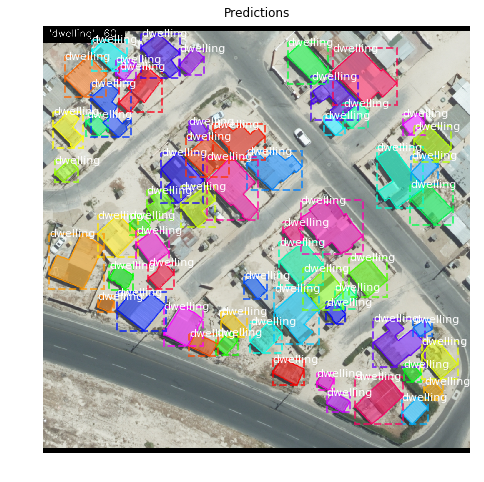

In [14]:
# Test on a random image
image_id = random.choice(dataset_val.image_ids)
original_image, image_meta, gt_class_id, gt_bbox, gt_mask =\
    modellib.load_image_gt(dataset_val, inference_config, 
                           image_id, use_mini_mask=False)

log("original_image", original_image)
log("image_meta", image_meta)
log("gt_class_id", gt_class_id)
log("gt_bbox", gt_bbox)
log("gt_mask", gt_mask)

visualize.display_instances(original_image, gt_bbox, gt_mask, gt_class_id, 
                            dataset_train.class_names, title="Predictions", figsize=(8, 8))

Processing 1 images
image                    shape: (1024, 1024, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max: 1024.00000  int64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32


/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


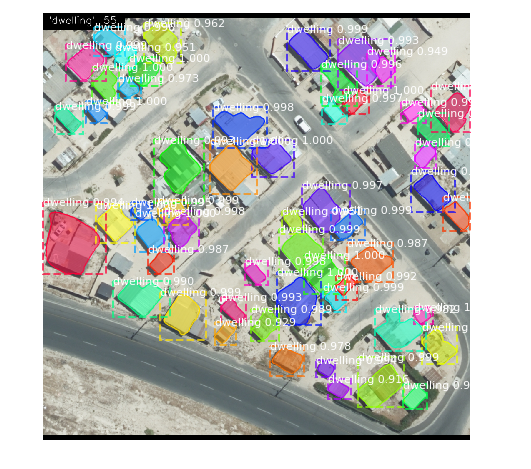

In [15]:
results = model.detect([original_image], verbose=1)

r = results[0]
visualize.display_instances(original_image, r['rois'], r['masks'], r['class_ids'], 
                            dataset_val.class_names, r['scores'], ax=get_ax())

In [12]:
# Compute VOC-Style mAP @ IoU=0.5
# Running on 10 images. Increase for better accuracy.
image_ids = np.random.choice(dataset_val.image_ids, 10)
APs = []
for image_id in image_ids:
    # Load image and ground truth data
    image, image_meta, gt_class_id, gt_bbox, gt_mask =\
        modellib.load_image_gt(dataset_val, inference_config,
                               image_id, use_mini_mask=False)
    molded_images = np.expand_dims(modellib.mold_image(image, inference_config), 0)
    # Run object detection
    results = model.detect([image], verbose=0)
    r = results[0]
    # Compute AP
    AP, precisions, recalls, overlaps =\
        utils.compute_ap(gt_bbox, gt_class_id, gt_mask,
                         r["rois"], r["class_ids"], r["scores"], r['masks'])
    APs.append(AP)
    
print("mAP: ", np.mean(APs))

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/skimage/transform/_warps.py:110:

mAP:  0.8704561534011864


# Run Detection

In [12]:
class_names = 'dwelling'

Processing 1 images
image                    shape: (1094, 1279, 3)       min:   46.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max: 1279.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32


/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


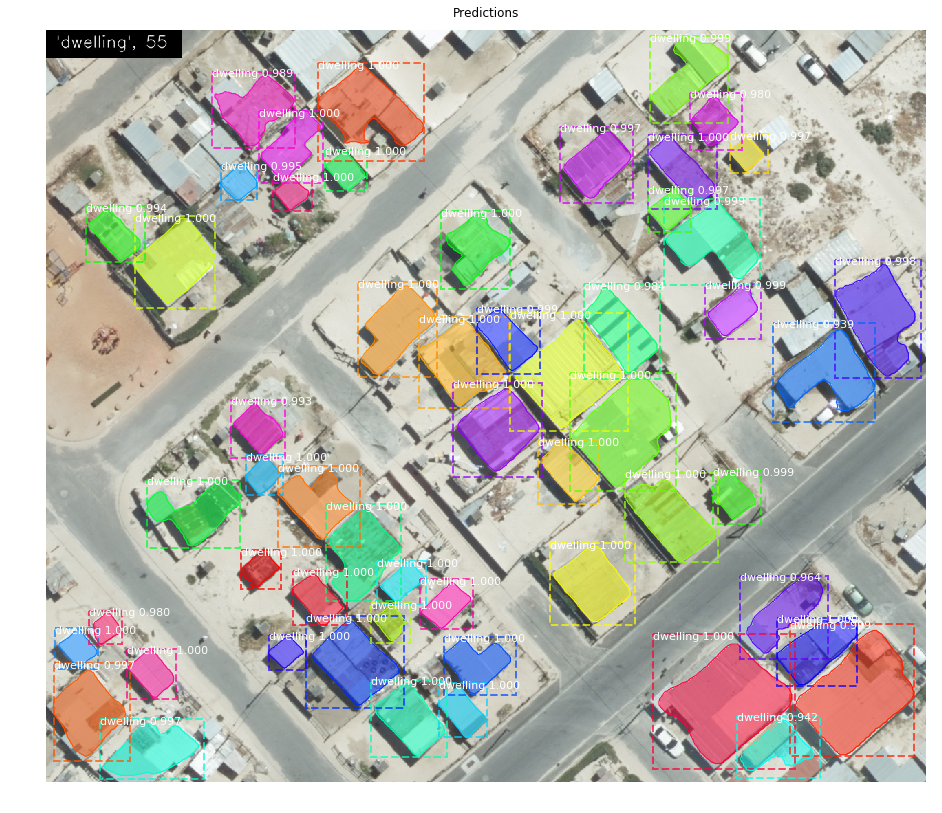

In [13]:
# Load a random image from the images folder

image = skimage.io.imread('/home/ubuntu/Mask_RCNN/samples/dwelling/detect/dwelling010.jpg')

# Run detection
results = model.detect([image], verbose=1)

# Visualize results

r = results[0]
visualize.display_instances(image, r['rois'], r['masks'], r['class_ids'], 
                            dataset_val.class_names, r['scores'],
                            title="Predictions")

#visualize.display_instances(image, r['rois'], r['masks'], r['class_ids'], class_names, r['scores'])

In [3]:
!~/.local/bin/tensorboard — logdir="/home/ubuntu/logs/dwelling20180809T1404"

/bin/sh: 1: /home/ubuntu/.local/bin/tensorboard — logdir=/home/ubuntu/logs/dwelling20180809T1404: not found
